In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal import iirnotch, filtfilt, welch
import numpy as np
import mne
import scipy, pywt
from pprint import pprint


In [2]:
# Import dataset
eeg_data = pd.read_csv('Muse_Recording.csv')
eeg_data

,timestamps,TP9,AF7,AF8,TP10,Right AUX
0,1.718226e+09,-36.133,-33.691,-54.199,-55.664,0.0
1,1.718226e+09,-60.547,-44.922,-57.617,-59.570,0.0
2,1.718226e+09,-74.707,-47.852,-60.059,-66.406,0.0
3,1.718226e+09,-68.359,-48.340,-63.477,-66.895,0.0
4,1.718226e+09,-54.199,-43.457,-59.082,-58.105,0.0
...,...,...,...,...,...,...
14131,1.718226e+09,-32.715,-946.289,-35.156,-40.039,0.0
14132,1.718226e+09,-9.277,-731.445,-32.715,-21.484,0.0
14133,1.718226e+09,-20.020,-667.480,-28.809,-37.598,0.0
14134,1.718226e+09,-30.273,-832.031,-25.391,-44.434,0.0


In [ ]:
# Time duration from the number of samples
# duration : duration (in secs)
# num_samples : number of samples
# sampling_rate : sampling rate


sampling_rate = 256 #Hz for Muse 2
nyq = 0.5*sampling_rate

# Get the number of samples (i.e., rows)
num_samples = eeg_data.shape[0]

duration = num_samples / sampling_rate

print(f"Since, there are {num_samples} samples, the trial lasts: {duration}s. Nyquist's freq: {nyq}")

Since, there are 14136 samples, the trial lasts: 55.21875s. Nyquist's freq: 128.0


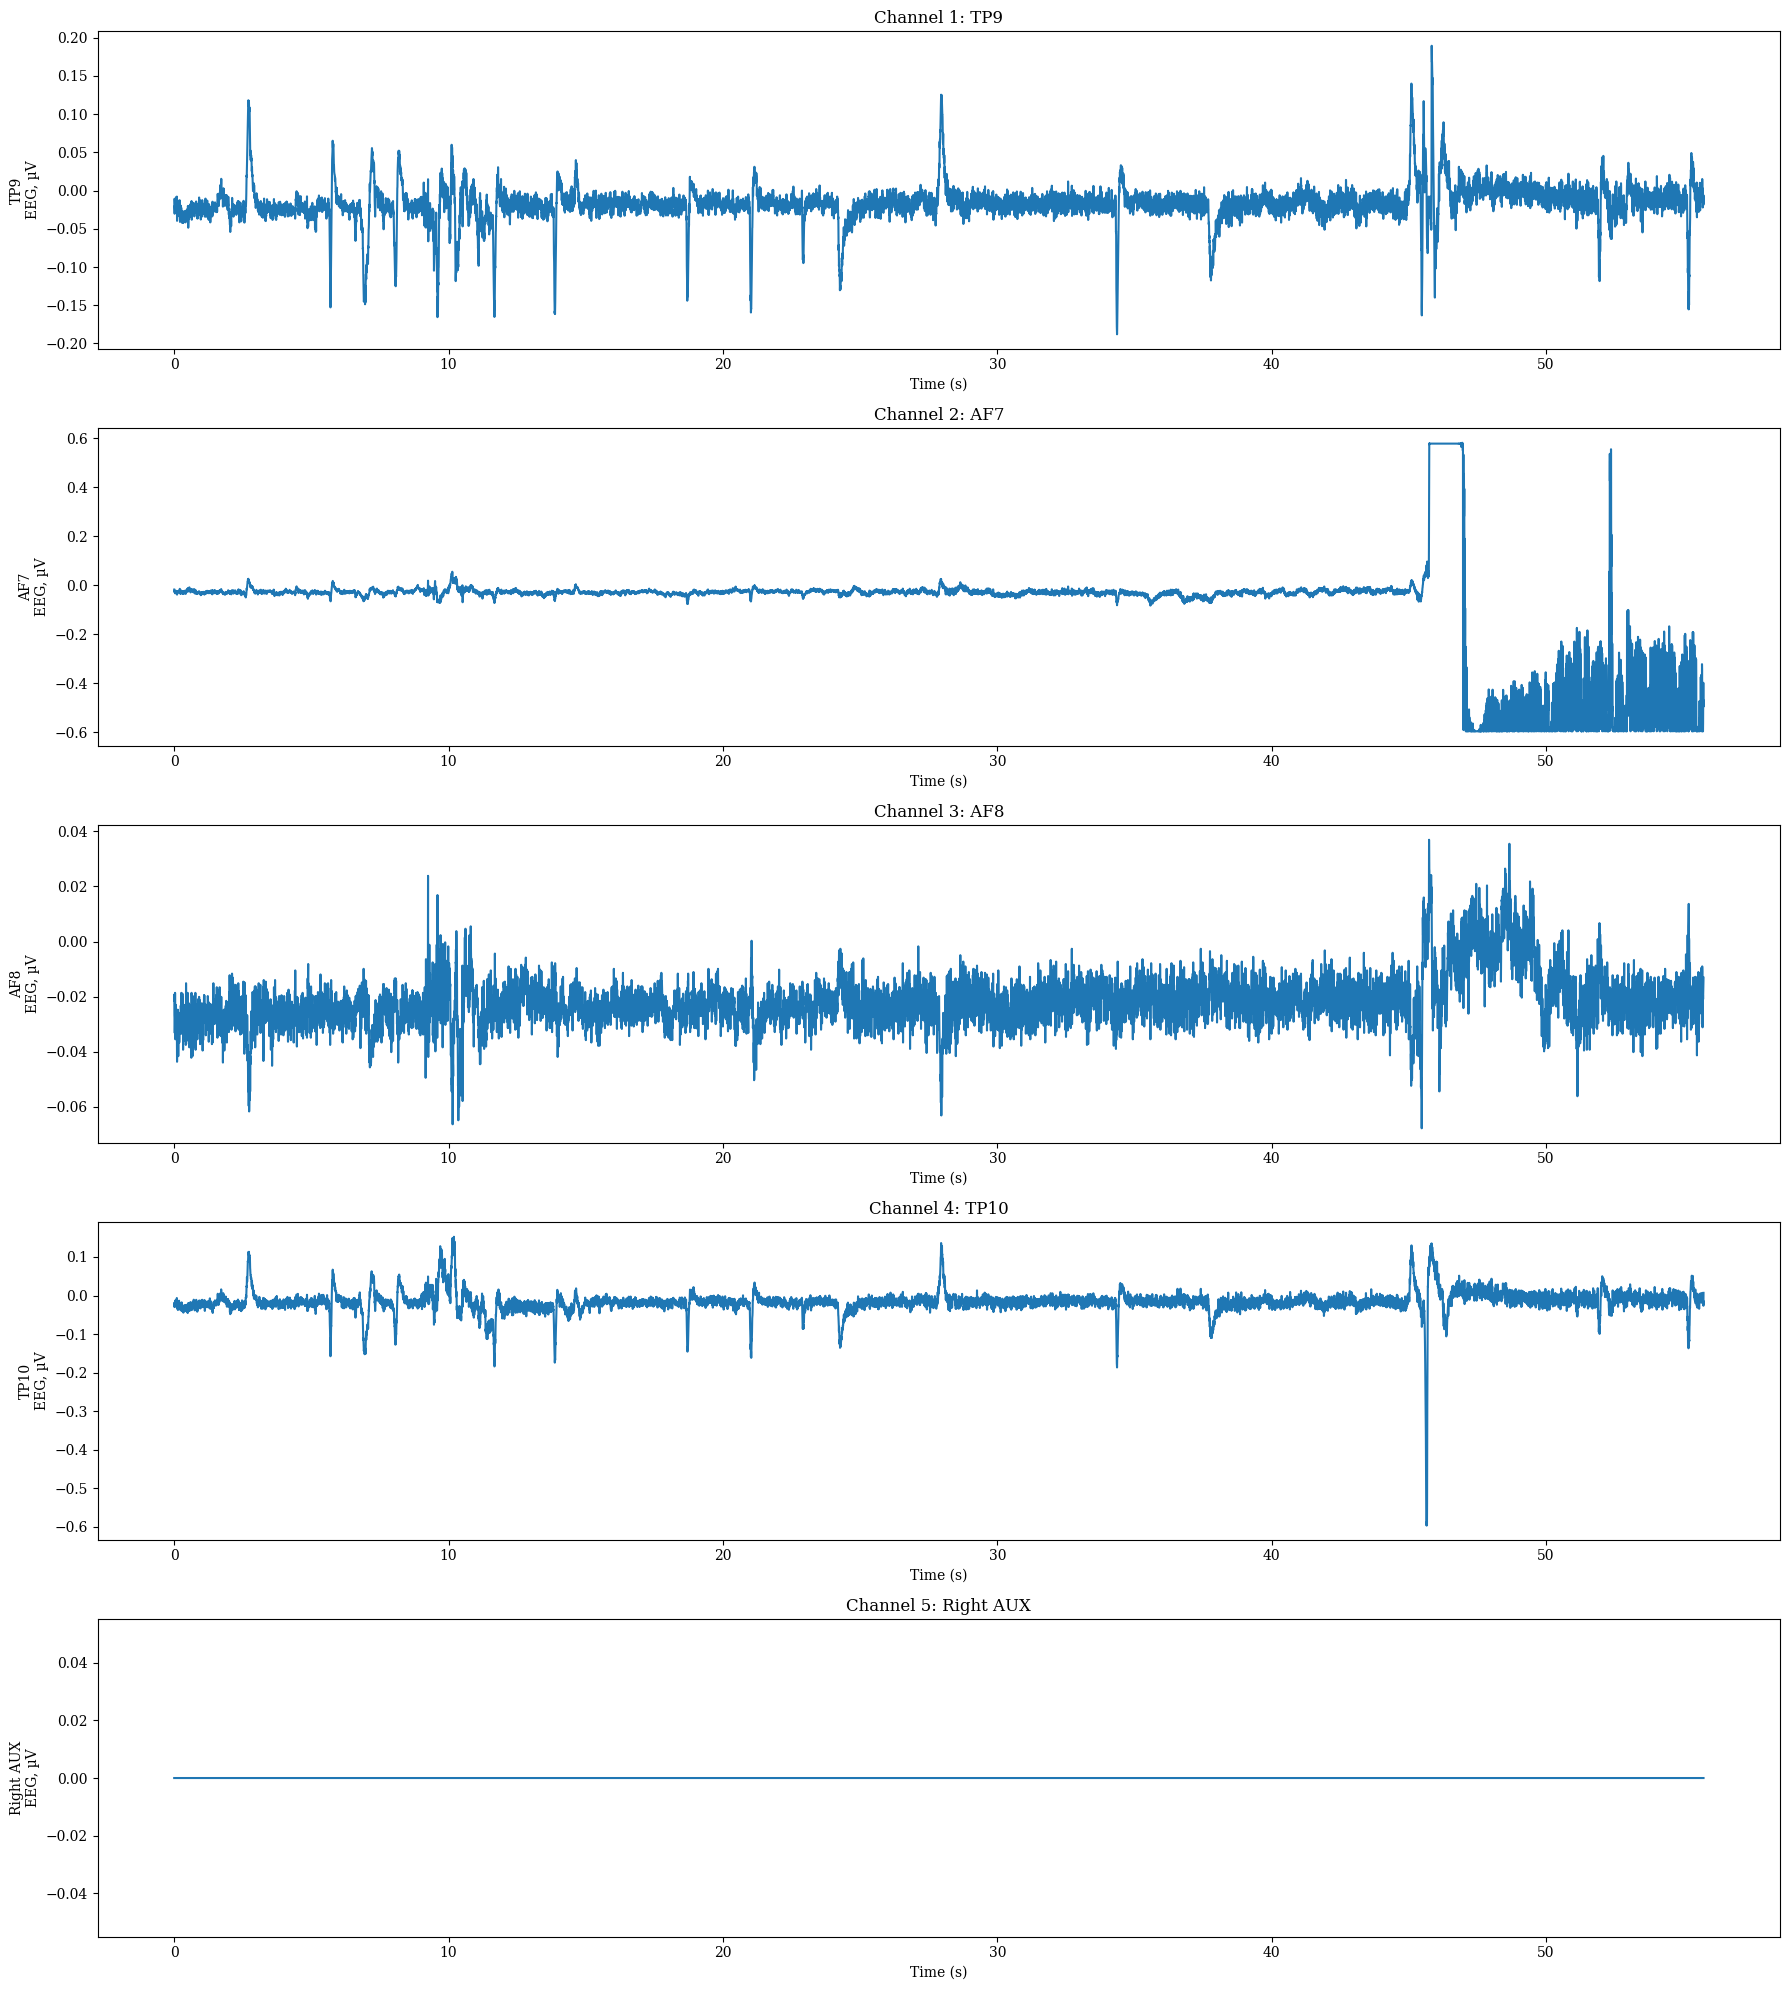

In [60]:

def plot_all_eeg_channels(eeg_data, show_time=True):
    fig, axes = plt.subplots(5, 1, figsize=(18, 20))  # 5 EEG channels
    channel_labels = eeg_data.columns[1:]  # Skip the timestamp column

    for ch in range(5):
        ax = axes[ch]

        # Extract and scale data
        data = eeg_data.iloc[200:, ch + 1]  # Skip timestamp column
        data = 10000 * data / 16777215  # Convert to microvolts

        # Time or sample x-axis
        if show_time:
            x = [i / sampling_rate for i in range(len(data))]
            xlabel = "Time (s)"
        else:
            x = list(range(len(data)))
            xlabel = "Sample"

        # Plot
        ax.plot(x, data)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(f'{channel_labels[ch]}\nEEG, µV')
        ax.set_title(f'Channel {ch+1}: {channel_labels[ch]}')

    plt.tight_layout()
    plt.show()

plot_all_eeg_channels(eeg_data, show_time=True)

In [9]:
def butter_highpass_filter(data, cutoff, order):
    """High-Pass Butterworth filter
    Args:
        data (array like): eeg data array.
        cutoff (float): cutoff frequency.
        order (int): order of the filter
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq #normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data
    
def butter_lowpass_filter(data, cutoff, order):
    """Low-Pass Butterworth filter
    Args:
        data (array like): eeg data array.
        cutoff (float): cutoff frequency.
        order (int): order of the filter
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq #normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

def notch_filter(data, freq=60.0, Q=30.0, fs=250):
    """Applies a notch filter at the specified frequency (e.g., 60Hz).
    
    Args:
        data (array-like): Input EEG signal.
        freq (float): Frequency to remove (default 60Hz).
        Q (float): Quality factor. Higher Q = narrower notch.
        fs (float): Sampling frequency in Hz.
        
    Returns:
        array: Filtered signal.
    """
    w0 = freq / (fs / 2)  # Normalize frequency (Nyquist)
    b, a = iirnotch(w0, Q)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

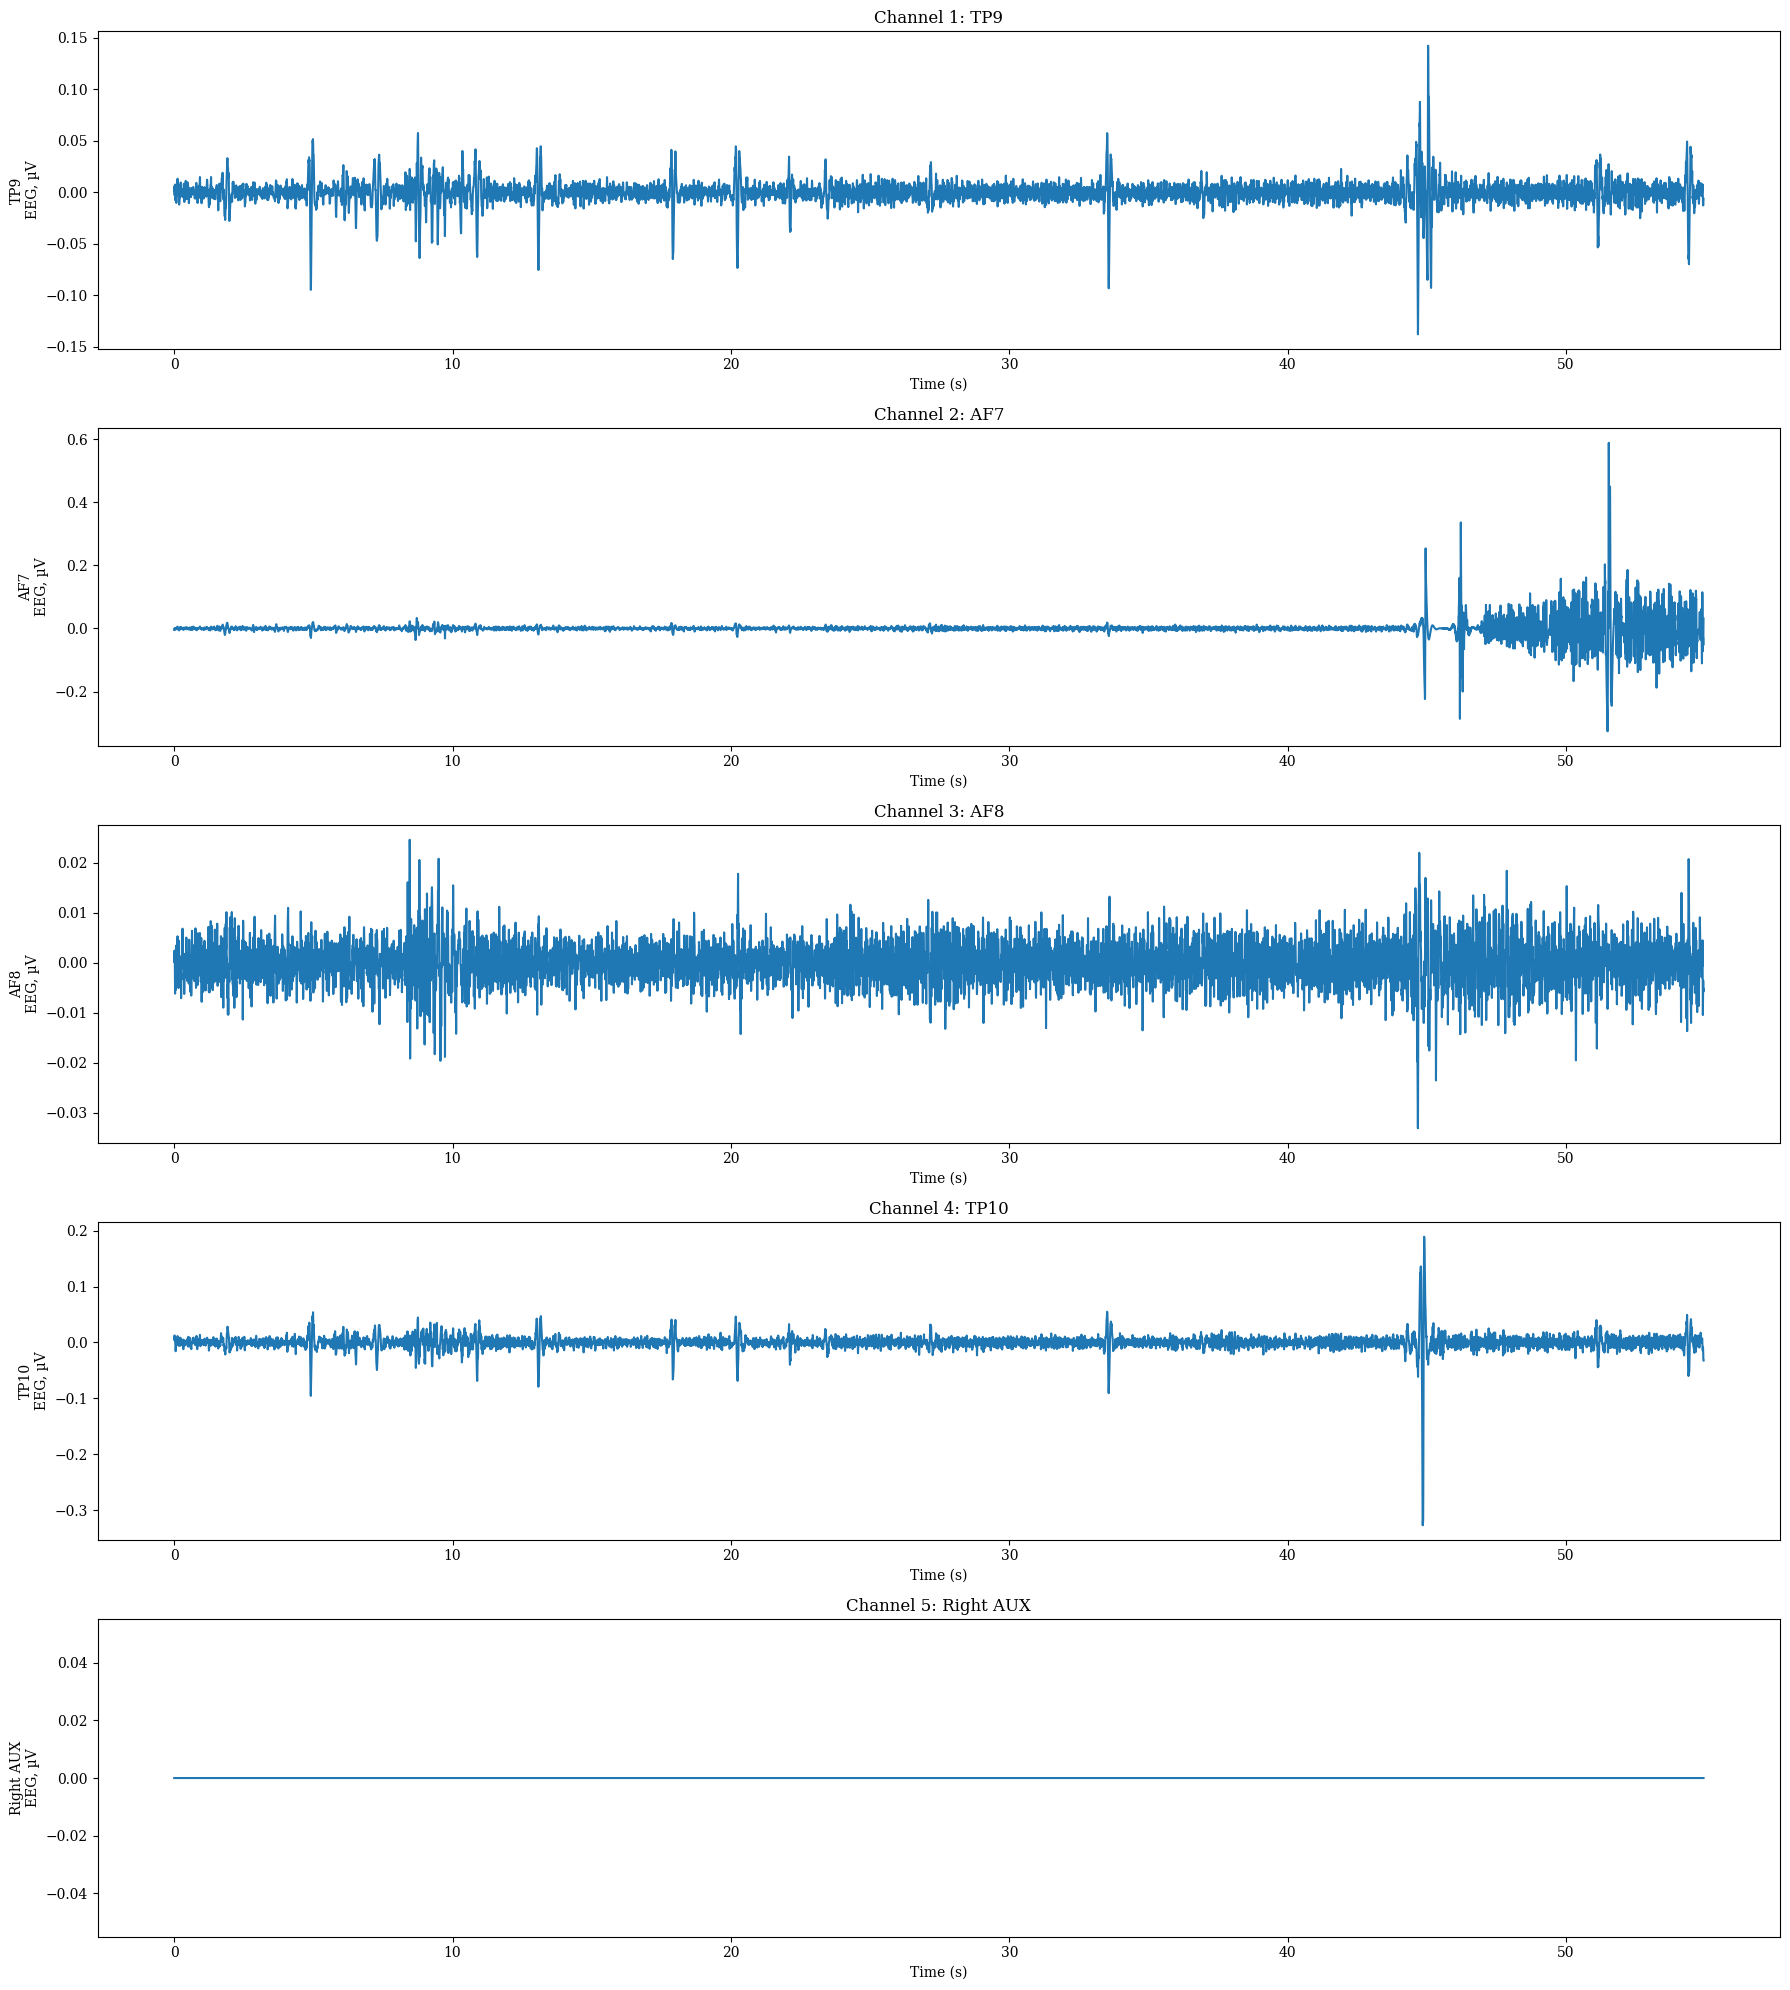

In [62]:
eeg_data_filtered = pd.DataFrame()

# Only iterate over the 5 EEG channels (columns 1 to 5)
for channel in range(0, 6):
    raw = eeg_data.iloc[200:, channel]

    # Apply filters
    filtered = butter_highpass_filter(raw, cutoff=4, order=4)
    filtered = butter_lowpass_filter(filtered, cutoff=45, order=4)
    filtered = notch_filter(filtered, freq=60.0, Q=30.0, fs=256)

    # Store in filtered DataFrame using original column name
    eeg_data_filtered[eeg_data.columns[channel]] = filtered


plot_all_eeg_channels(eeg_data_filtered, show_time=True)

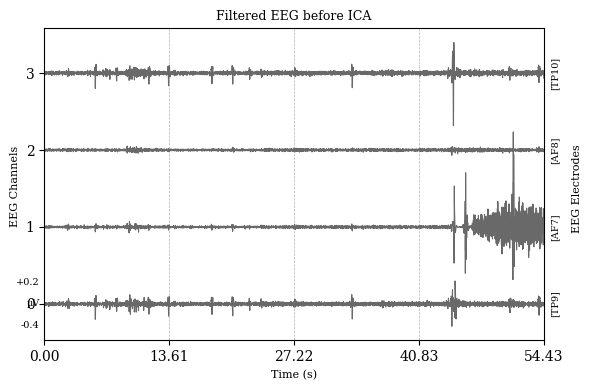

In [87]:
# n_channels = eeg_data_filtered.shape[1]  # number of channels
# plt.plot(eeg_data_filtered + range(1000, 1000*n_channels+1000, 1000))
# plt.yticks(range(1000, 1000*n_channels+1000, 1000), range(0, n_channels))
# plt.ylabel('Channels, µV')
# plt.xlabel('Sample')
# plt.title("Data before ICA")
# plt.show()




# Parameters
sampling_rate = 256  # Hz
duration_sec = 55
num_samples = int(duration_sec * sampling_rate)




# Slice EEG data
eeg_segment = eeg_data_filtered[['TP9', 'AF7', 'AF8', 'TP10']].iloc[:num_samples, :]
time = np.arange(len(eeg_segment)) / sampling_rate
n_channels = eeg_segment.shape[1]
offsets = list(range(800, 800 * n_channels + 800, 800))  # n_channels == 4

# Electrode labels per channel
electrode_labels = ['[TP9]', '[AF7]', '[AF8]', '[TP10]']

assert len(electrode_labels) == n_channels == len(offsets), "Mismatch in labels or offsets"

# Plot config
plt.figure(figsize=(6, 4))

for ch in range(n_channels):
    plt.plot(time, eeg_segment.iloc[:, ch] + offsets[ch], color='dimgray', linewidth=0.8)

# Grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add rotated electrode labels on the right side
for i, label in enumerate(electrode_labels):
    plt.text(55.2, offsets[i], label, fontsize=7, color='black',
             va='center', rotation=90)

# Right-side label for EEG electrodes
plt.text(57.5, np.mean(offsets), 'EEG Electrodes', fontsize=8,
         rotation=90, va='center', ha='left')

# Add vertical scale bar to show amplitude [-0.4, +0.2] µV
scale_x = -1.5  # horizontal position of scale bar
scale_y_bottom = offsets[0] - 220  # -0.4 µV from baseline
scale_y_top = offsets[0] + 220     # +0.2 µV from baseline

# Draw scale bar line
plt.plot([scale_x, scale_x], [scale_y_bottom, scale_y_top],
         color='black', linewidth=1)

# Add scale labels
plt.text(scale_x + 1, scale_y_bottom, '-0.4', fontsize=7, va='center', ha='right')
plt.text(scale_x + 1, scale_y_top, '+0.2', fontsize=7, va='center', ha='right')
plt.text(scale_x + 1, (scale_y_bottom + scale_y_top) / 2,
         'µV', fontsize=7, va='center', ha='right')

# Axis ticks and labels
xticks = np.linspace(0, time[-1], num=5)
plt.xticks(xticks)
plt.yticks(offsets, range(n_channels))
plt.ylabel('EEG Channels ', fontsize=8)
plt.xlabel('Time (s)', fontsize=8)
plt.title("Filtered EEG before ICA", fontsize=9)

# Layout and export settings
plt.xlim(0, time[-1])
plt.rcParams['font.family'] = 'serif'
plt.tight_layout()

# High-resolution save
plt.savefig("before_ica.pdf", dpi=600, bbox_inches='tight')  # vector PDF

plt.show()



/home/multivac/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:613: RuntimeWarning: invalid value encountered in divide
  K = (u / d).T[:n_components]  # see (6.33) p.140


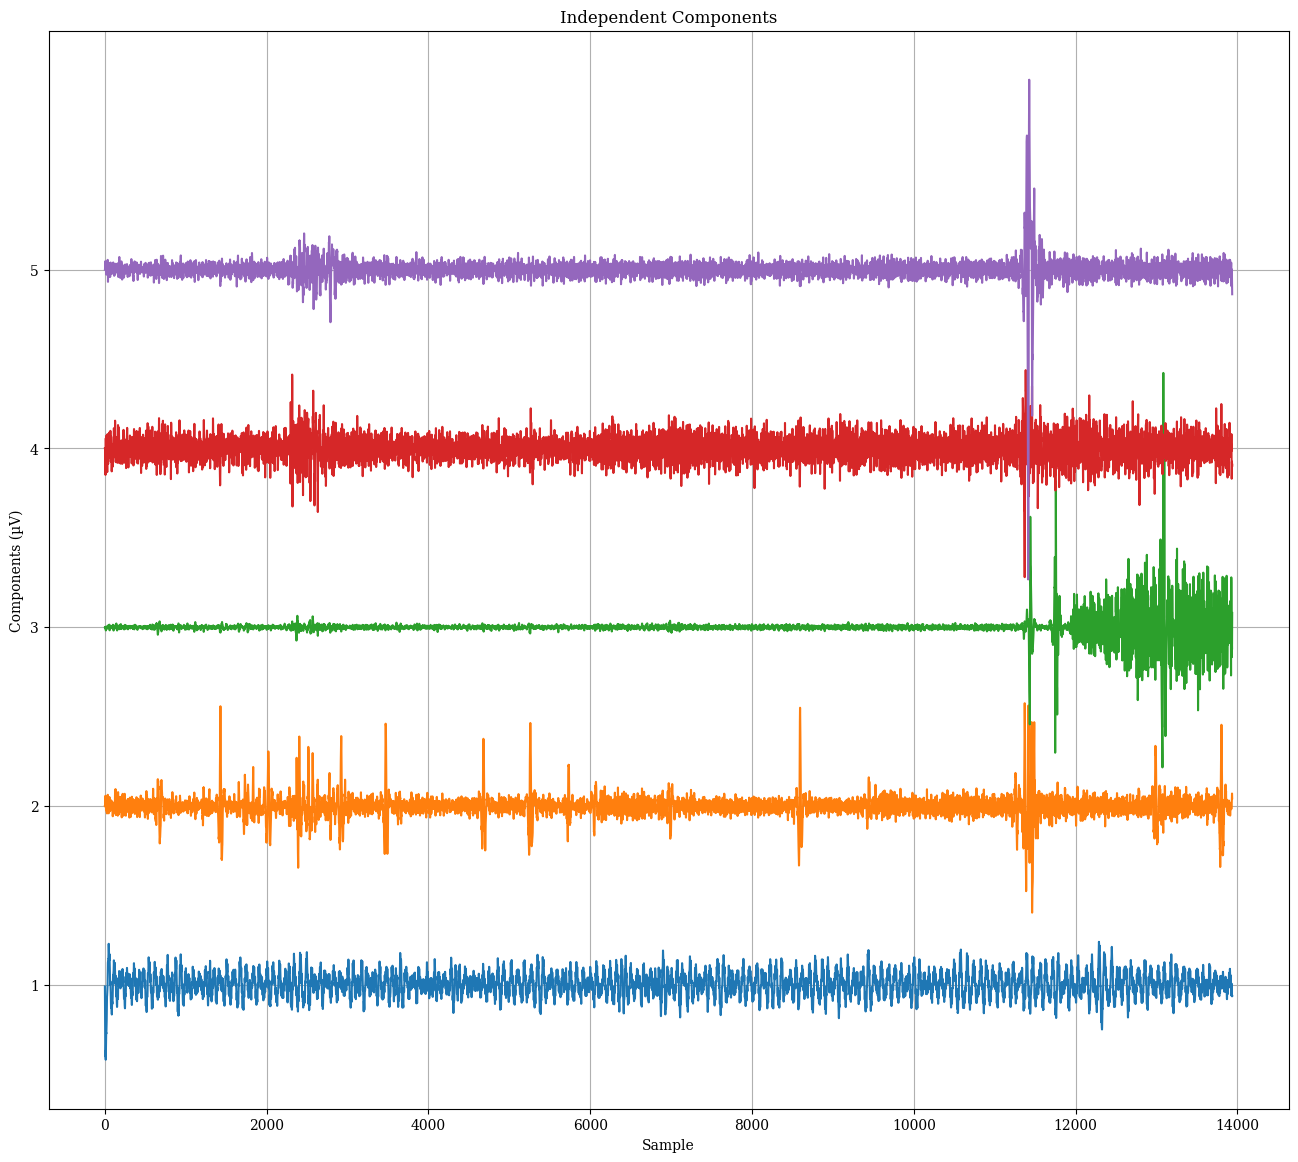

In [52]:

from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
import numpy as np
"""
The code first creates an instance of the FastICA class from the scikit-learn library,
specifying the number of components to be extracted as 8. The fit method is then called on the data_bp_filtered data, which performs the ICA decomposition and learns the unmixing matrix.
The transform method applies the learned unmixing matrix to the original data, resulting in the independent components stored in the components variable.
Next, the code plots the independent components using plt.plot,
with each component vertically offset by adding a constant value from the range(1, 1*n_channels+1, 1) sequence. This separation makes it easier to visualize the individual components.
"""

ica = FastICA(n_components=5)

# Ensure this is shaped (samples, channels)
data_after_band_pass_filter_reshape = eeg_data_filtered

# Run ICA

components = ica.fit_transform(data_after_band_pass_filter_reshape)

# Plot the components
offset = 15
plt.figure(figsize=(16, 14))
for i in range(5):
    plt.plot(components[:, i] + offset * i)

plt.yticks(np.arange(0, offset * 5, offset), np.arange(1, 6))
plt.ylabel('Components (µV)')
plt.xlabel('Sample')
plt.title('Independent Components')
plt.grid(True)
plt.show()


ValueError: 'c' argument has 6 elements, which is inconsistent with 'x' and 'y' with size 5.

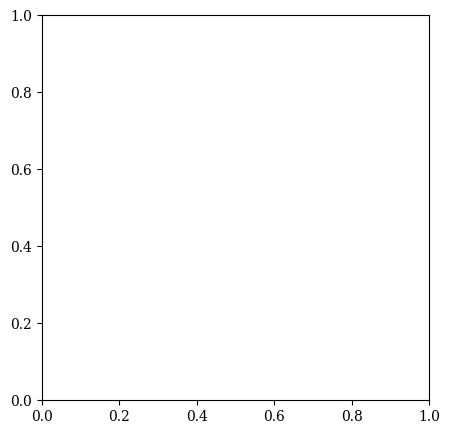

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Mixing matrix: shape (channels, components)
mixing_matrix = ica.mixing_

# Muse 2 channel names
channel_names = ['TP9', 'AF7', 'AF8', 'TP10', 'AUX']

# Estimated 2D positions for these electrodes (rough layout)
channel_positions = {
    'TP9':  (0.2, 0.4),  # Left ear
    'AF7':  (0.35, 0.8), # Left forehead
    'AF8':  (0.65, 0.8), # Right forehead
    'TP10': (0.8, 0.4),  # Right ear
    'AUX':  (0.5, 0.2),  # Below/auxiliary
}
positions = np.array([channel_positions[ch] for ch in channel_names])

# Plot topographies for all ICA components
for comp_idx in range(mixing_matrix.shape[1]):
    topography = mixing_matrix[:, comp_idx]

    plt.figure(figsize=(5, 5))
    sc = plt.scatter(positions[:, 0], positions[:, 1], c=topography, s=400, cmap='coolwarm', edgecolors='k')
    for i, label in enumerate(channel_names):
        plt.text(positions[i, 0], positions[i, 1], label, ha='center', va='center', fontsize=9, color='black')
    
    plt.colorbar(sc, shrink=0.6)
    plt.title(f'Topography of Component {comp_idx}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [38]:
# import mne
# import numpy as np
# import matplotlib.pyplot as plt

# # Assume you already have this:
# mixing_matrix = ica.mixing_
# mixing_matrix_uv = (mixing_matrix / 16777215)
# n_components = mixing_matrix_uv.shape[1]

# # Create MNE info object
# sfreq = 250.0  # dummy value
# info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types="eeg")
# montage = mne.channels.make_standard_montage("standard_1020")

# # Prepare figure
# fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2 rows × 4 columns
# axes = axes.flatten()

# for i in range(8):  # Only first 8 components
#     topo_vector = mixing_matrix_uv[:, i].reshape(-1, 1)
#     evoked = mne.EvokedArray(topo_vector, info)
#     evoked.set_montage(montage, on_missing="ignore")

#     # Plot into specified axes
#     mne.viz.plot_topomap(
#         data=topo_vector[:, 0],
#         pos=evoked.info,
#         axes=axes[i],
#         show=False,
#         names=None,
#         contours=6,
#         sensors=True,
#         sphere=0.09,
#         cmap="RdBu_r",
#         outlines='head'
#     )

#     axes[i].set_title(f'ICA {i}', fontsize=10)

# # Final layout
# plt.tight_layout()
# plt.savefig("ica_topoplots_grid.png", dpi=300, bbox_inches='tight')
# plt.show()

import mne
import numpy as np
import matplotlib.pyplot as plt

# Normalize mixing matrix to µV
mixing_matrix = ica.mixing_
mixing_matrix_uv = mixing_matrix/10
n_components = mixing_matrix_uv.shape[1]

# Create MNE info
sfreq = 256.0
info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types="eeg")
montage = mne.channels.make_standard_montage("standard_1020")

# Set up figure
fig, axes = plt.subplots(2, 4, figsize=(7.1, 3.5))  # Wider to fit colorbars
axes = axes.flatten()

for i in range(8):  # First 8 components
    topo_vector = mixing_matrix_uv[:, i].reshape(-1, 1)
    evoked = mne.EvokedArray(topo_vector, info)
    evoked.set_montage(montage, on_missing="ignore")

    # Plot topomap and get image
    im, cn = mne.viz.plot_topomap(
        data=topo_vector[:, 0],
        pos=evoked.info,
        axes=axes[i],
        show=False,
        contours=6,
        sensors=True,
        sphere=0.09,
        cmap="RdBu_r",
        outlines='head'
    )

    axes[i].set_title(f'IC # {i}', fontsize=10)

    # Add individual colorbar
    cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=6)
    cbar.set_label('µV', fontsize=8)

    # Disable scientific notation
    cbar.ax.ticklabel_format(style='plain')
    cbar.ax.yaxis.offsetText.set_visible(False)

# Final layout
plt.tight_layout()
# Uncomment to save:
plt.savefig("ica_topoplots.pdf", dpi=600, bbox_inches='tight')  # vector PDF
plt.show()


NameError: name 'channel_names' is not defined

In [ ]:
ica = FastICA(n_components=8)
components = ica.fit_transform(eeg_data)

# Plot each component and visually find the one that looks like an eye blink
for i in range(8):
    plt.plot(components[150:, i])
    plt.title(f"Component {i}")
    plt.show()

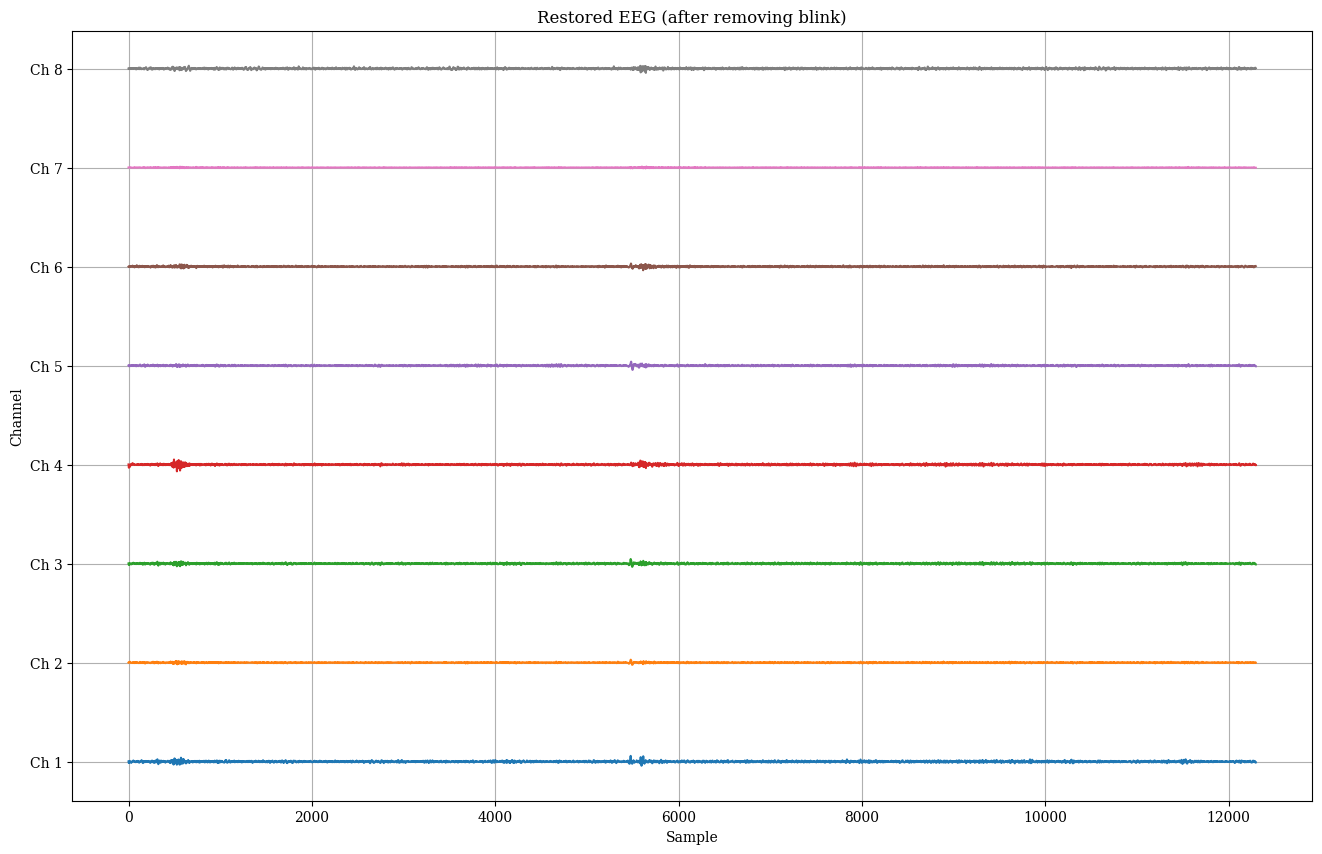

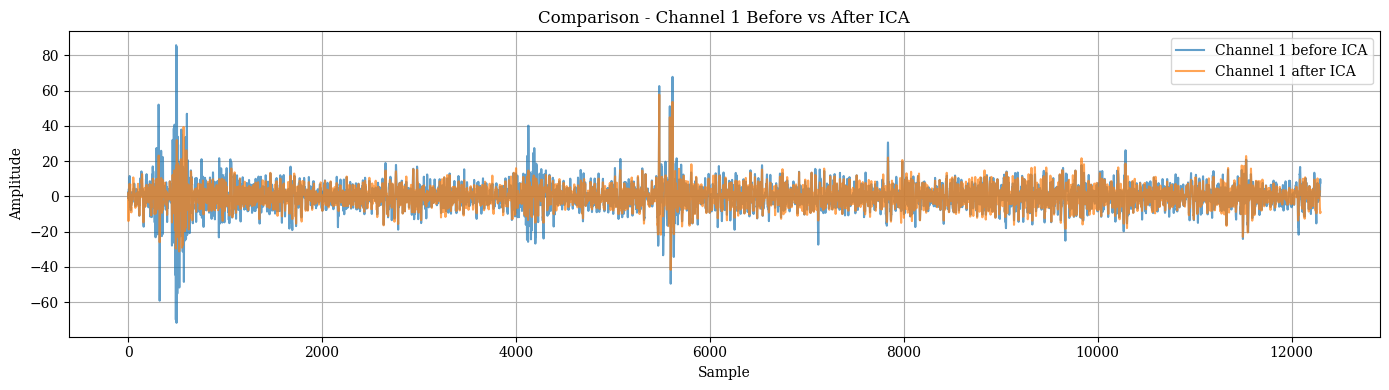

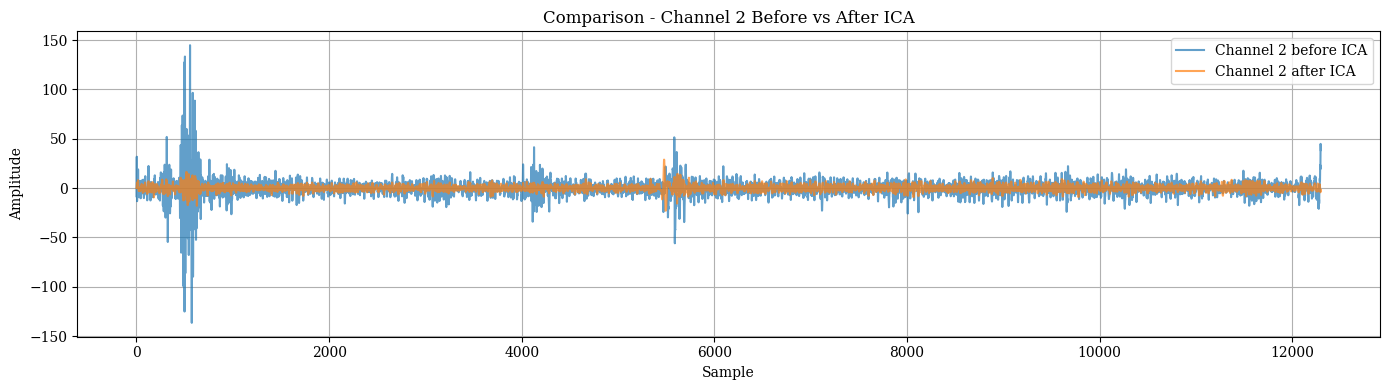

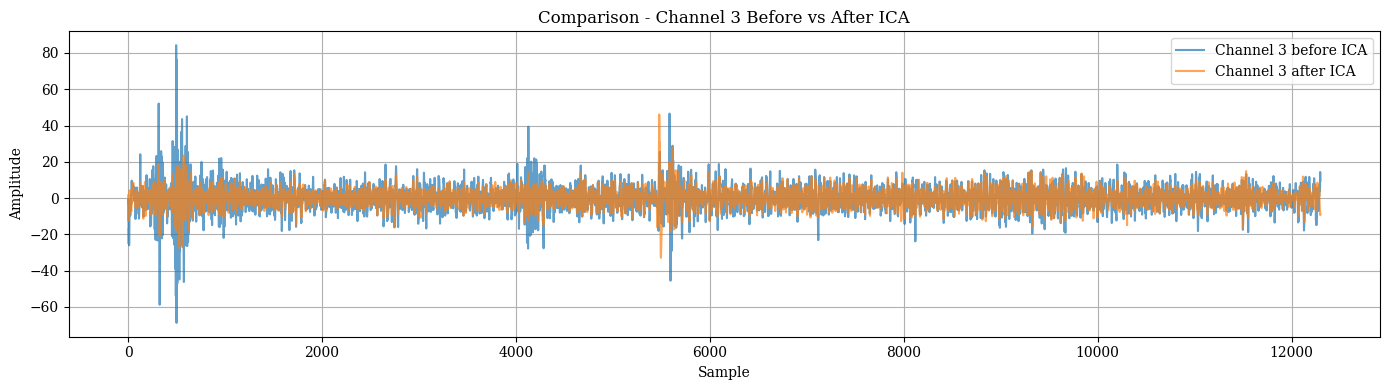

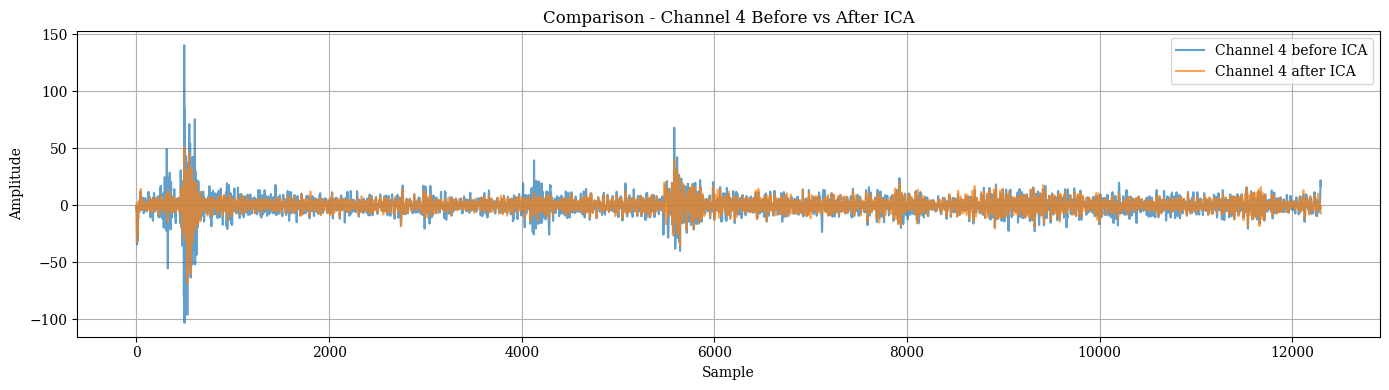

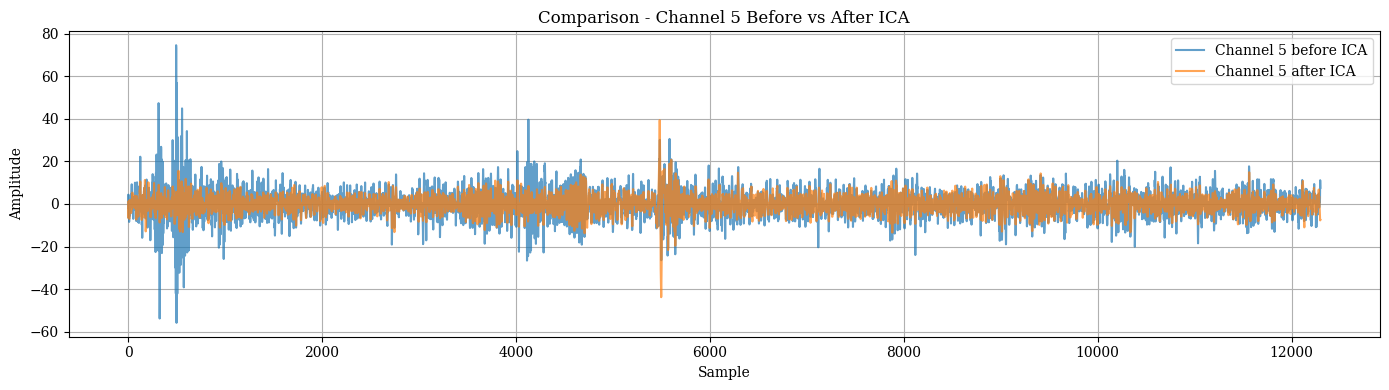

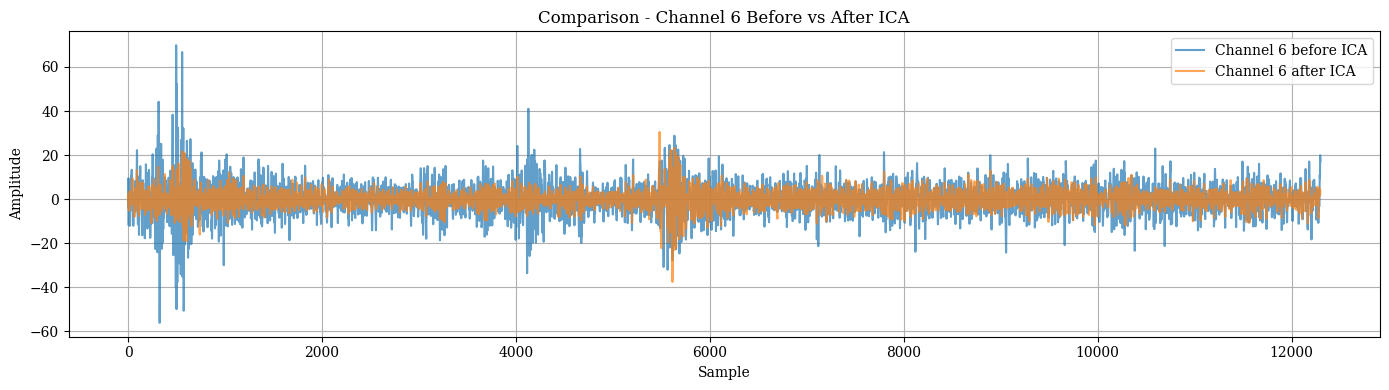

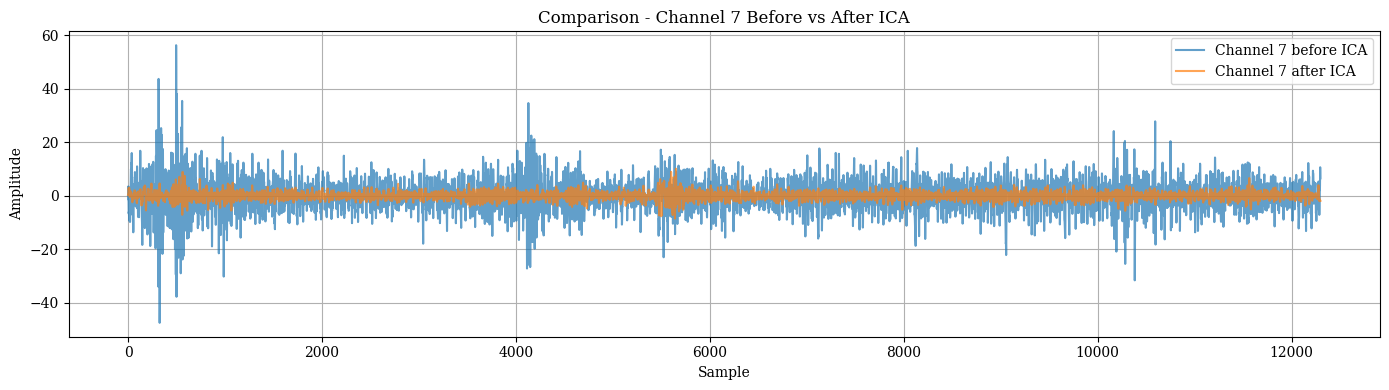

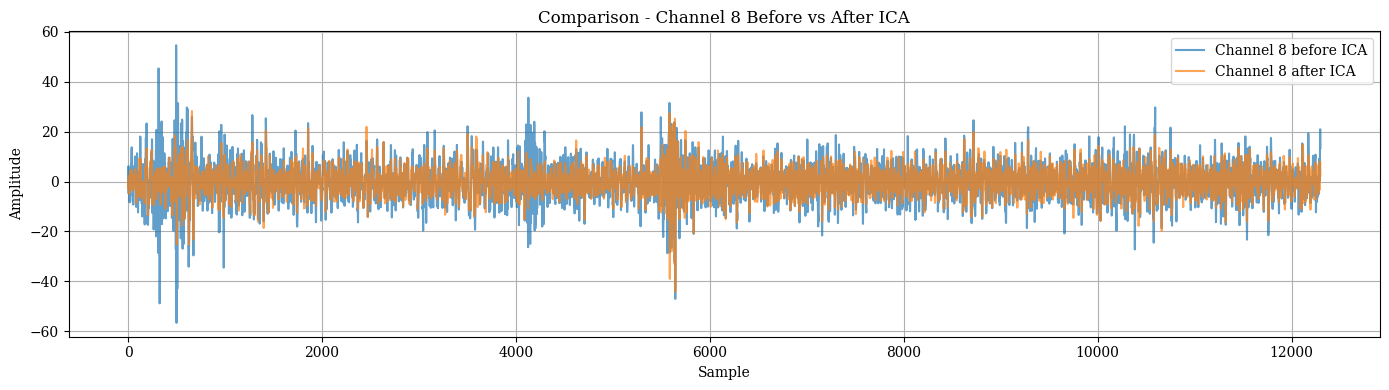

In [26]:
"""
After performing Independent Component Analysis (ICA) and visualizing the independent components, this script proceeds to remove all components except for the eye blink component (component 2) from the components matrix.
This is achieved by setting all other component values to zero using indexing operations.
The inverse_transform method of the ICA object is then called with the modified components matrix.
This method reconstructs the original data by applying the inverse of the unmixing matrix learned during the ICA decomposition.
The resulting data, stored in the restored variable, represents the original EEG data with the eye blink component removed.
Next, the code plots the restored data using plt.plot, with each channel vertically offset by adding a constant value from the range(1000, 1000*n_channels+1000, 1000) sequence.
This separation makes it easier to visualize the individual channels.
"""

components[:, 2] = 0  # remove the blink
components[:, 5] = 0  # remove the blink
components[:, 7] = 0
# components[:, 6] = 0  # remove the blink

# Reconstruct EEG signal
restored = ica.inverse_transform(components)

# Plot restored EEG with vertical offsets
offsets = np.arange(1000, 1000 * n_channels + 1, 1000)
plt.figure(figsize=(16, 10))
for i in range(n_channels):
    plt.plot(restored[:, i] + offsets[i])

plt.yticks(offsets, [f"Ch {i+1}" for i in range(n_channels)])
plt.ylabel('Channel')
plt.xlabel('Sample')
plt.title("Restored EEG (after removing blink)")
plt.grid(True)
plt.show()

# Compare all channels before/after — one plot per channel
for i in range(n_channels):
    plt.figure(figsize=(14, 4))
    plt.plot(eeg_data_filtered.iloc[:, i], label=f'Channel {i + 1} before ICA', alpha=0.7)
    plt.plot(restored[:, i], label=f'Channel {i + 1} after ICA', alpha=0.7)
    plt.ylabel('Amplitude')
    plt.xlabel('Sample')
    plt.title(f'Comparison - Channel {i + 1} Before vs After ICA')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Convert to DataFrame
restored_df = pd.DataFrame(restored)



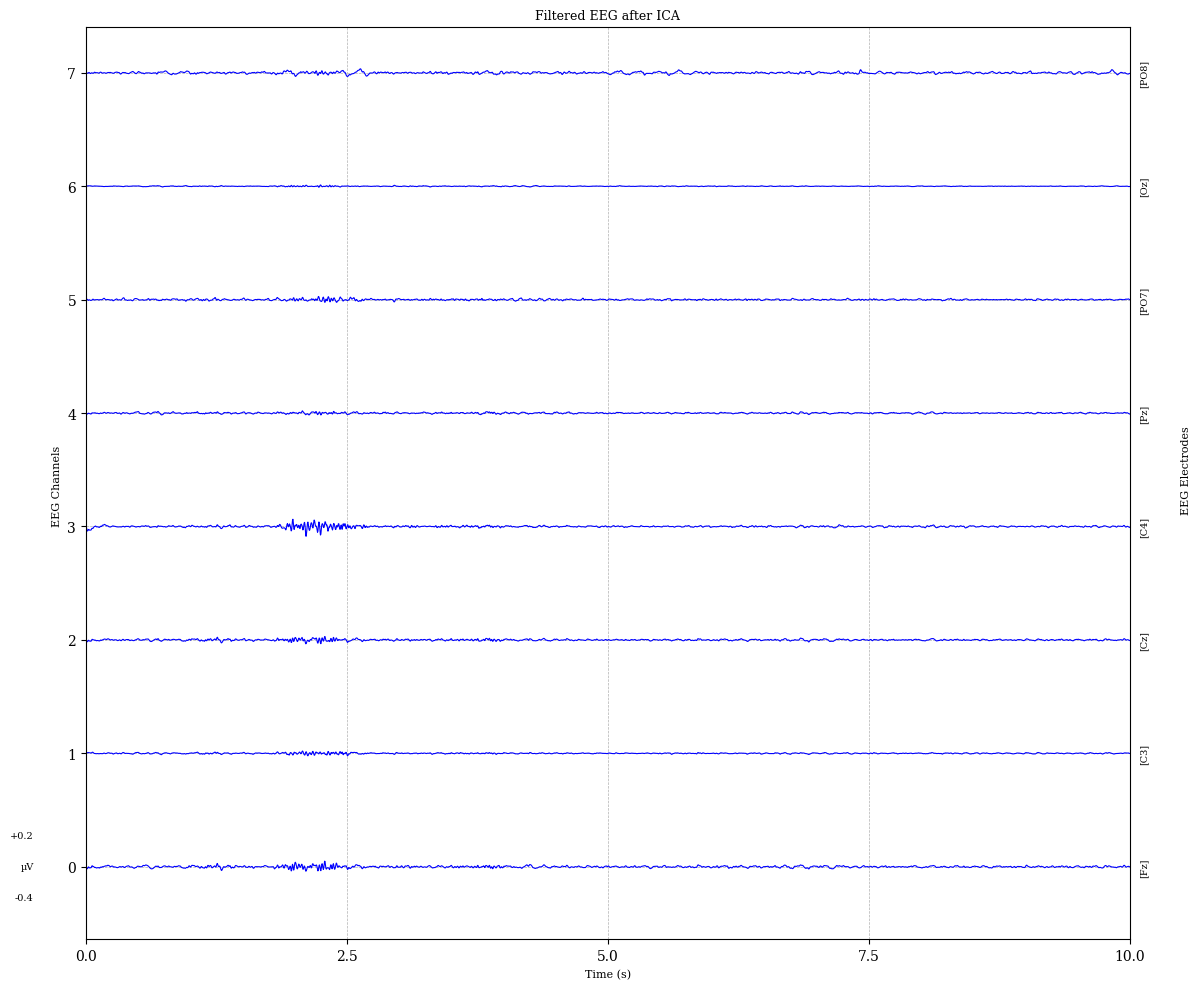

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sampling_rate = 250  # Hz
duration_sec = 10.01
num_samples = int(duration_sec * sampling_rate)

# Slice EEG data
eeg_segment = restored_df.iloc[:num_samples, :]
time = np.arange(num_samples) / sampling_rate
n_channels = eeg_segment.shape[1]
offsets = list(range(800, 800 * n_channels + 800, 800))

# Electrode labels per channel
electrode_labels = ['[Fz]', '[C3]', '[Cz]', '[C4]', '[Pz]', '[PO7]', '[Oz]', '[PO8]']

# Plot config
plt.figure(figsize=(12, 10))
for ch in range(n_channels):
    plt.plot(time, eeg_segment.iloc[:, ch] + offsets[ch], color='#0000FF', linewidth=0.8)


# Grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add rotated electrode labels on the right side
for i, label in enumerate(electrode_labels):
    plt.text(10.1, offsets[i], label, fontsize=7, color='black',
             va='center', rotation=90)

# Right-side label for EEG electrodes
plt.text(10.5, np.mean(offsets), 'EEG Electrodes', fontsize=8,
         rotation=90, va='center', ha='left')

# Add vertical scale bar to show amplitude [-0.4, +0.2] µV
scale_x = -1.5  # horizontal position of scale bar
scale_y_bottom = offsets[0] - 220  # -0.4 µV from baseline
scale_y_top = offsets[0] + 220     # +0.2 µV from baseline

# Draw scale bar line
plt.plot([scale_x, scale_x], [scale_y_bottom, scale_y_top],
         color='black', linewidth=1)

# Add scale labels
plt.text(scale_x + 1, scale_y_bottom, '-0.4', fontsize=7, va='center', ha='right')
plt.text(scale_x + 1, scale_y_top, '+0.2', fontsize=7, va='center', ha='right')
plt.text(scale_x + 1, (scale_y_bottom + scale_y_top) / 2,
         'µV', fontsize=7, va='center', ha='right')

# Axis ticks and labels
xticks = np.linspace(0, time[-1], num=5)
plt.xticks(xticks)
plt.yticks(offsets, range(n_channels))
plt.ylabel('EEG Channels ', fontsize=8)
plt.xlabel('Time (s)', fontsize=8)
plt.title("Filtered EEG after ICA", fontsize=9)

# Layout and export settings
plt.xlim(0, time[-1])
plt.rcParams['font.family'] = 'serif'
plt.tight_layout()

# High-resolution save
#plt.savefig("after_ica.pdf", dpi=600, bbox_inches='tight')  # vector PDF

plt.show()

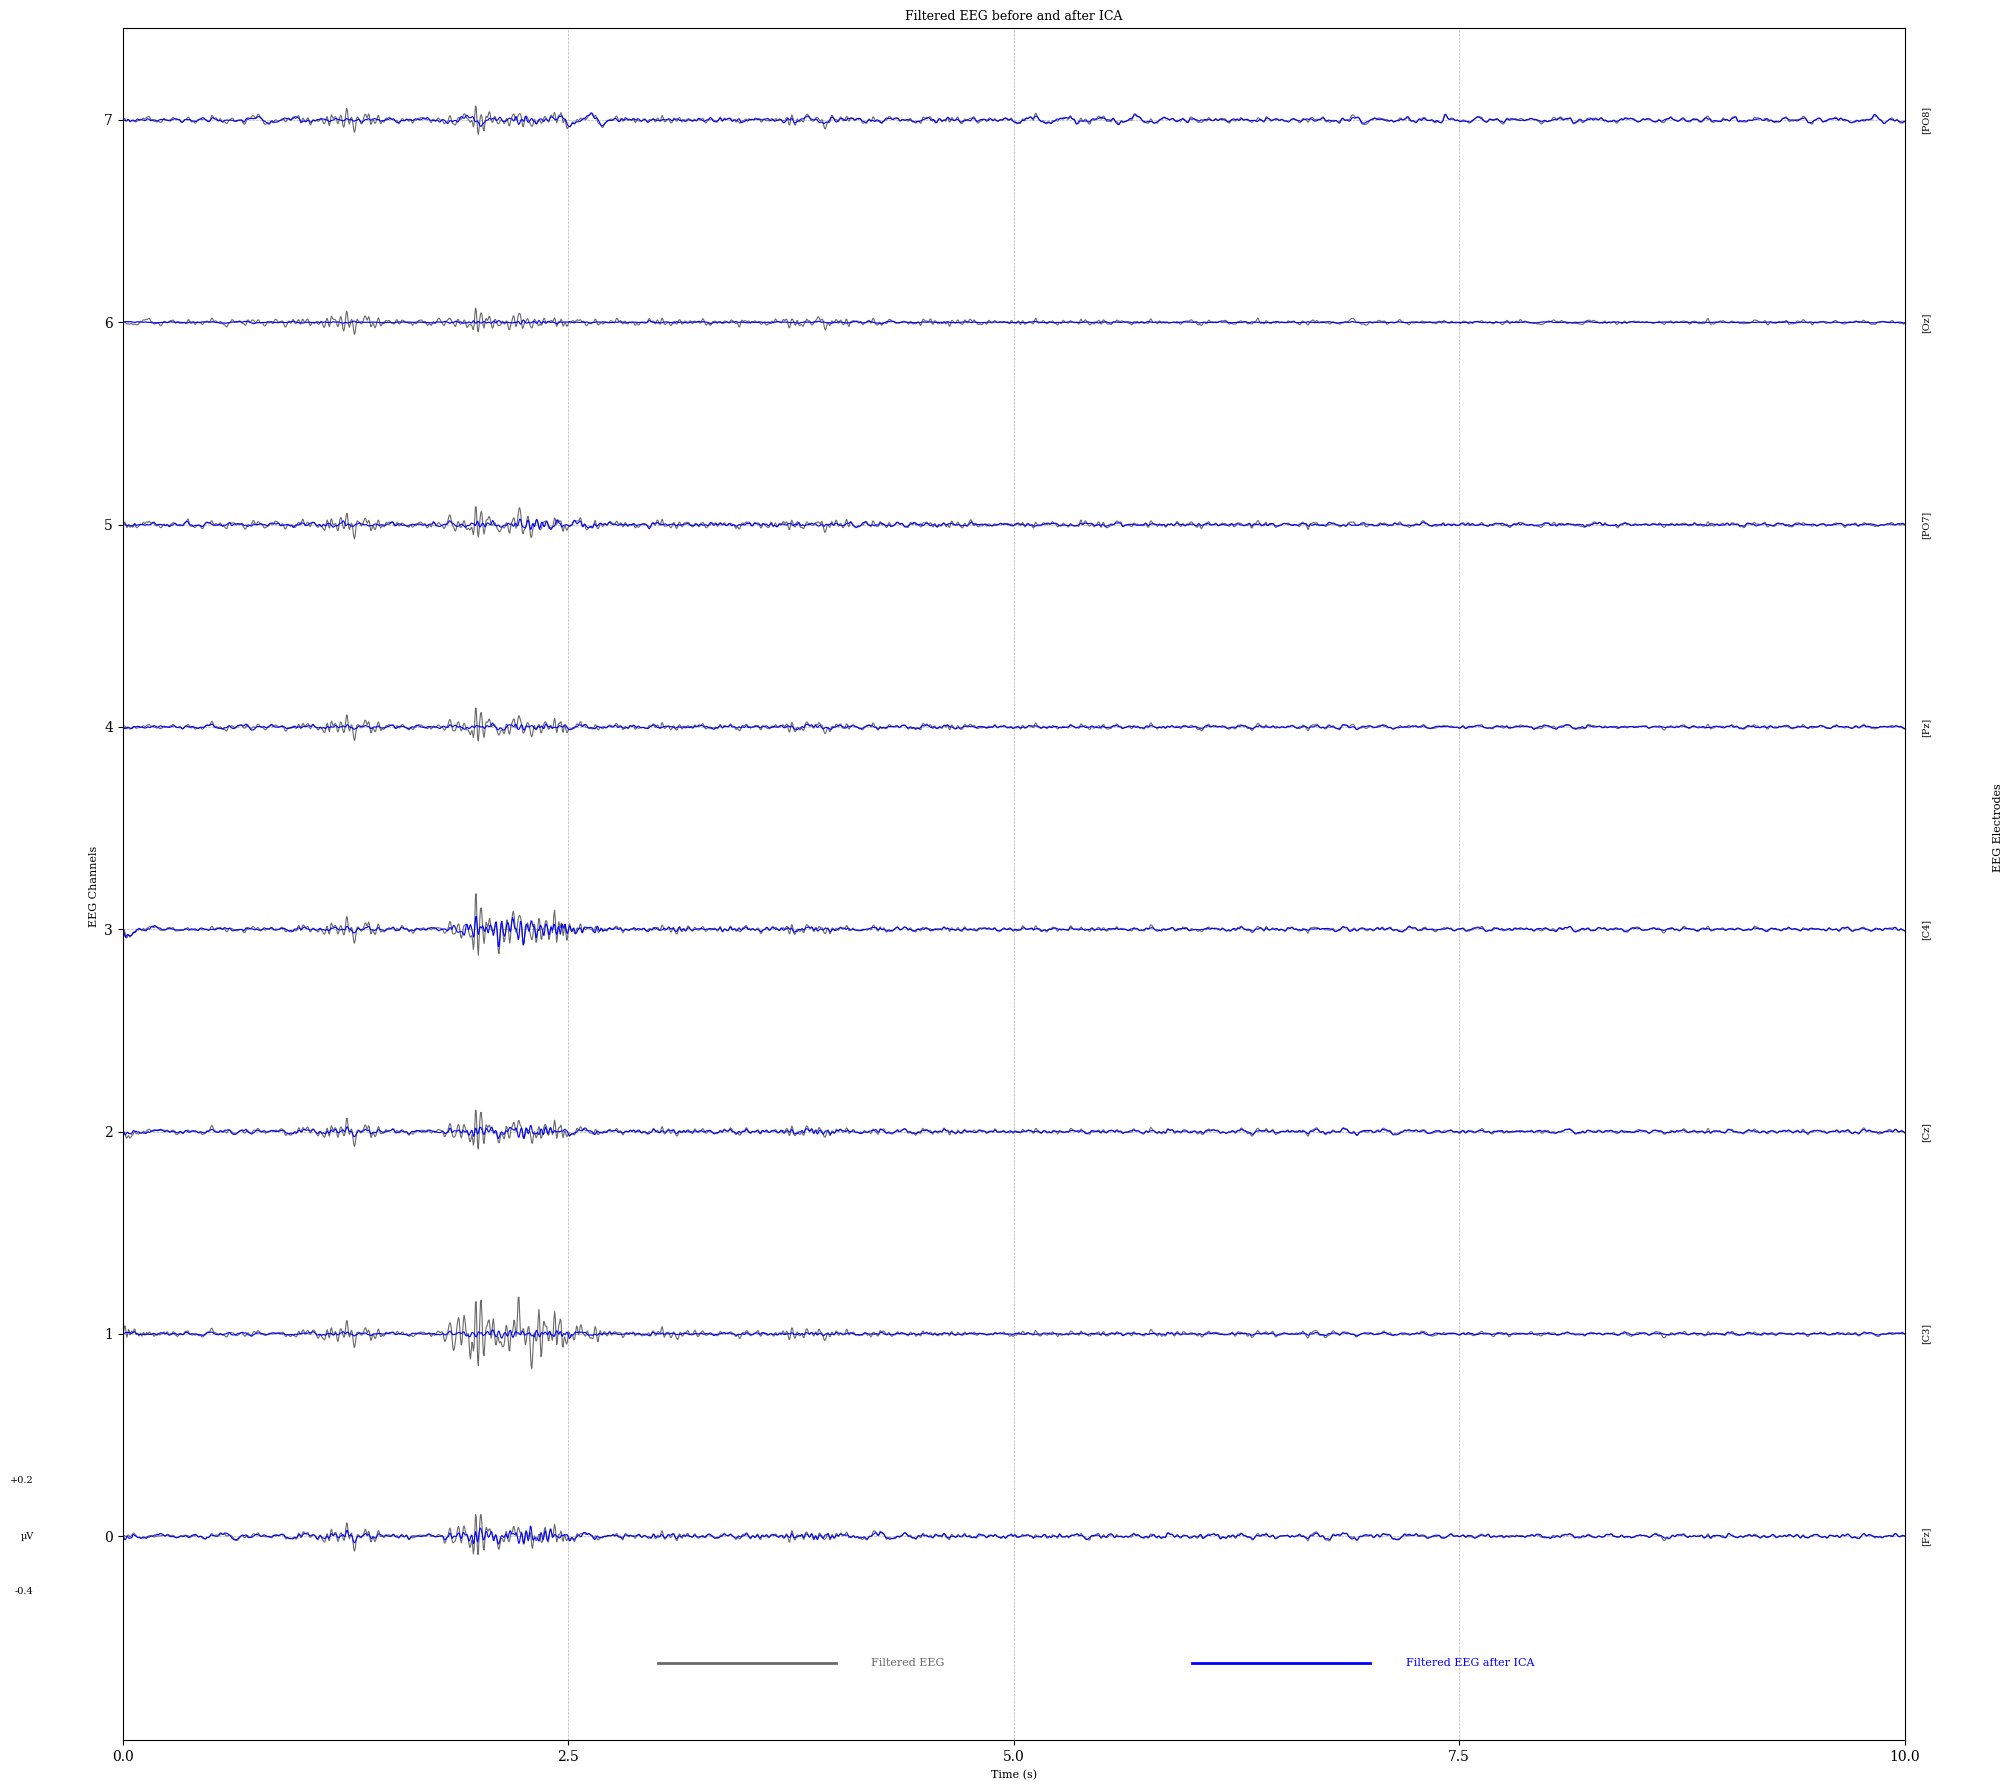

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sampling_rate = 250  # Hz
duration_sec = 10.01
num_samples = int(duration_sec * sampling_rate)

# Slice EEG data
eeg_before = eeg_data_filtered.iloc[:num_samples, :]
eeg_after = restored_df.iloc[:num_samples, :]
time = np.arange(num_samples) / sampling_rate
n_channels = eeg_before.shape[1]
offsets = list(range(800, 800 * n_channels + 800, 800))

# Electrode labels
electrode_labels = ['[Fz]', '[C3]', '[Cz]', '[C4]', '[Pz]', '[PO7]', '[Oz]', '[PO8]']

# Set up figure
plt.figure(figsize=(20, 18))

# Plot both signals per channel
for ch in range(n_channels):
    # Before ICA: dim gray
    plt.plot(time, eeg_before.iloc[:, ch] + offsets[ch], color='dimgray', linewidth=0.8)
    # After ICA: blue
    plt.plot(time, eeg_after.iloc[:, ch] + offsets[ch], color='#0000FF', linewidth=0.8)

# Grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add rotated electrode labels
for i, label in enumerate(electrode_labels):
    plt.text(10.1, offsets[i], label, fontsize=7, color='black',
             va='center', rotation=90)

plt.text(10.5, np.mean(offsets), 'EEG Electrodes', fontsize=8,
         rotation=90, va='center', ha='left')

# Vertical scale bar
scale_x = -1.5
scale_y_bottom = offsets[0] - 220
scale_y_top = offsets[0] + 220
plt.plot([scale_x, scale_x], [scale_y_bottom, scale_y_top], color='black', linewidth=1)
plt.text(scale_x + 1, scale_y_bottom, '-0.4', fontsize=7, va='center', ha='right')
plt.text(scale_x + 1, scale_y_top, '+0.2', fontsize=7, va='center', ha='right')
plt.text(scale_x + 1, (scale_y_bottom + scale_y_top) / 2, 'µV', fontsize=7, va='center', ha='right')

# Axes
xticks = np.linspace(0, time[-1], num=5)
plt.xticks(xticks)
plt.yticks(offsets, range(n_channels))
plt.ylabel('EEG Channels ', fontsize=8)
plt.xlabel('Time (s)', fontsize=8)
plt.title("Filtered EEG before and after ICA", fontsize=9)

# Layout and export
plt.xlim(0, time[-1])
plt.rcParams['font.family'] = 'serif'
plt.tight_layout()

# Add custom horizontal color-coded labels below x-axis
x_center = time[-1] / 2
y_base = 300  # baseline below plot area

# Line and label for "Filtered EEG"
plt.plot([x_center - 2, x_center - 1], [y_base, y_base], color='dimgray', linewidth=2)
plt.text(x_center - 0.8, y_base, 'Filtered EEG', fontsize=8, va='center', ha='left', color='dimgray')

# Line and label for "Filtered EEG after ICA"
plt.plot([x_center + 1, x_center + 2], [y_base, y_base], color='#0000FF', linewidth=2)
plt.text(x_center + 2.2, y_base, 'Filtered EEG after ICA', fontsize=8, va='center', ha='left', color='#0000FF')

# Save if needed
plt.savefig("combined_ica_plot.pdf", dpi=600, bbox_inches='tight')

plt.show()


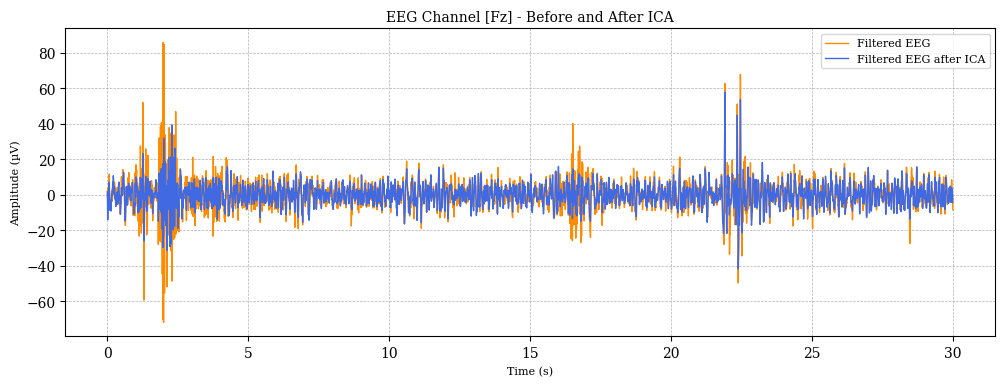

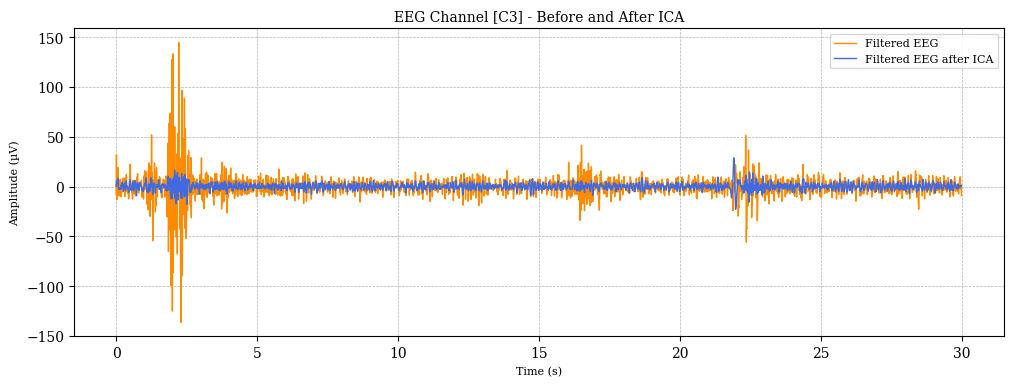

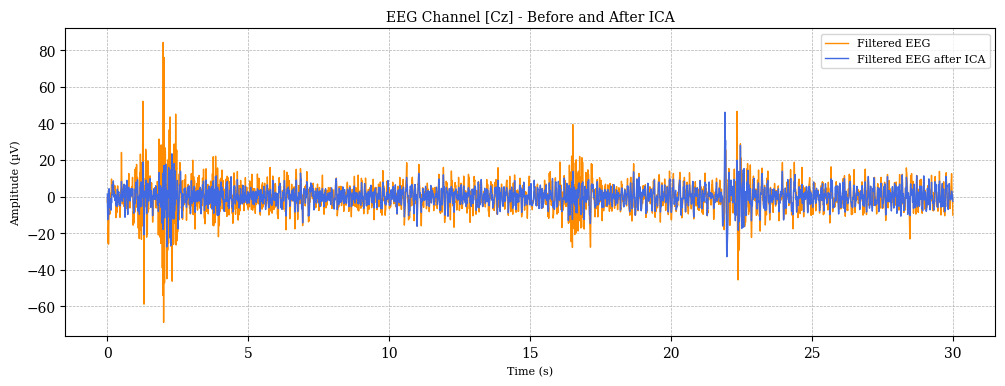

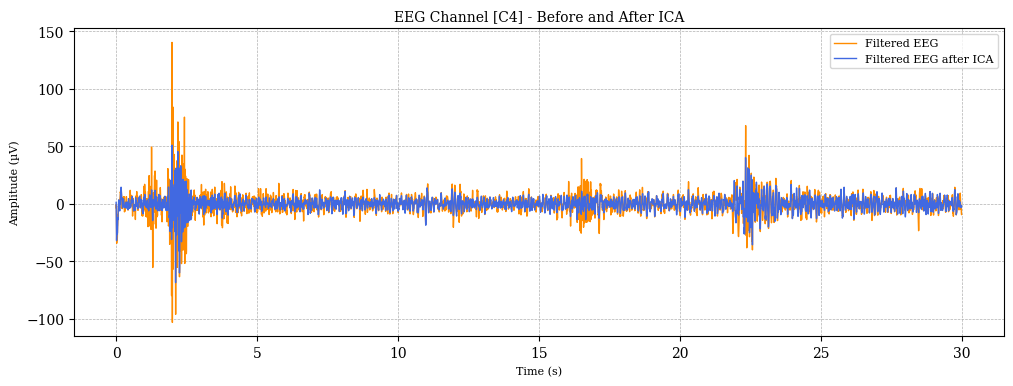

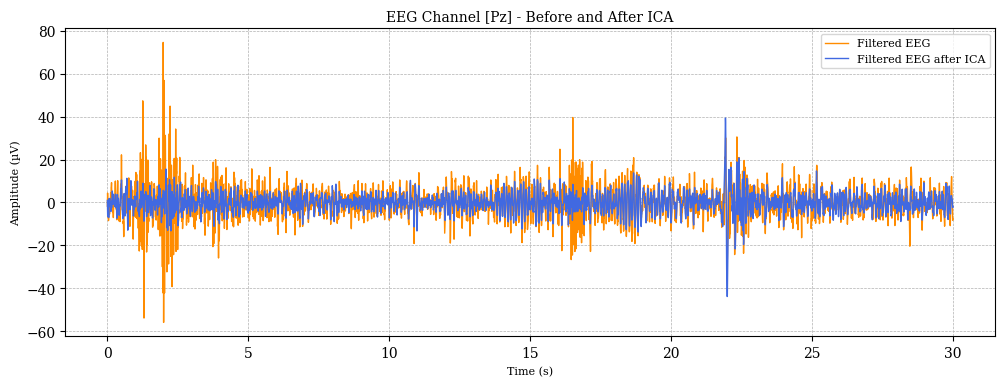

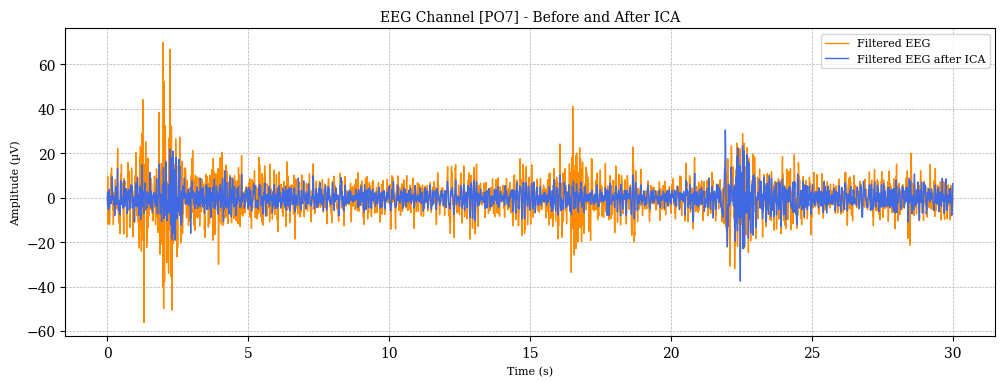

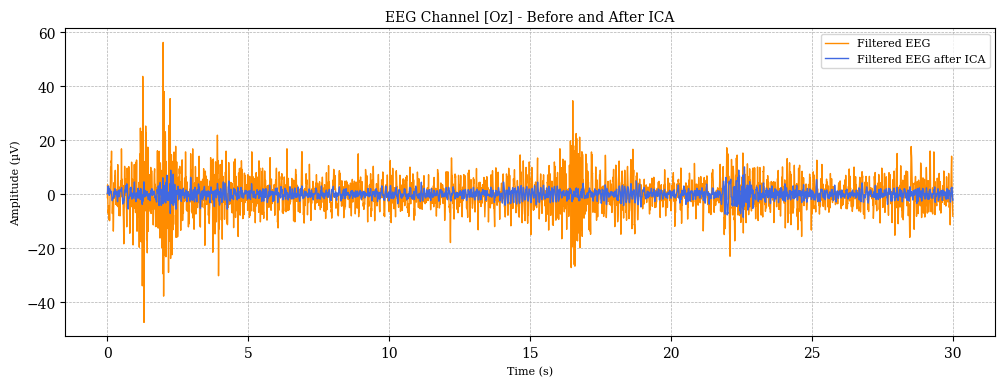

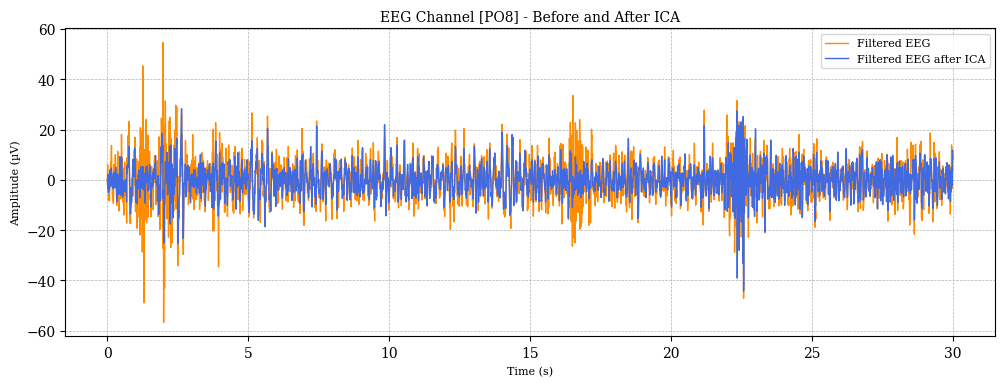

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parameters
sampling_rate = 250  # Hz
duration_sec = 30
num_samples = int(duration_sec * sampling_rate)

# Slice EEG data
eeg_before = eeg_data_filtered.iloc[:num_samples, :]
eeg_after = restored_df.iloc[:num_samples, :]
time = np.arange(num_samples) / sampling_rate
n_channels = eeg_before.shape[1]

# Electrode labels
electrode_labels = ['[Fz]', '[C3]', '[Cz]', '[C4]', '[Pz]', '[PO7]', '[Oz]', '[PO8]']

# Loop through each channel and display individual plots
for ch in range(n_channels):
    plt.figure(figsize=(12, 4))

    # Plot EEG before ICA (dim gray)
    plt.plot(time, eeg_before.iloc[:, ch], color='#FF8C00', linewidth=1, label='Filtered EEG')

    # Plot EEG after ICA (blue)
    plt.plot(time, eeg_after.iloc[:, ch], color='#4169E1', linewidth=1, label='Filtered EEG after ICA')

    # Adding grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Electrode label
    plt.title(f"EEG Channel {electrode_labels[ch]} - Before and After ICA", fontsize=10)
    plt.xlabel('Time (s)', fontsize=8)
    plt.ylabel('Amplitude (µV)', fontsize=8)

    # Legend
    plt.legend(loc='upper right', fontsize=8)

    # Save each plot as SVG
    plt.savefig(f"EEG_Channel_{electrode_labels[ch]}.svg", format='svg', dpi=300)

    # Display the plot
    plt.show()



In [ ]:
# def analyze_spectrum_metrics(data, fps, title, ax=None, xlim=(0, 60),            
#                              grid_lines=[8, 19, 29],
#                              highlight_freq=None, window_hz=0.5):
#     from scipy.fft import fft, fftfreq

#     n = len(data)
#     freqs = fftfreq(n, d=1/fps)[:n//2]
#     spectrum = abs(fft(data))[:n//2]
#     spectrum /= np.max(spectrum)  # Normalize to [0, 1]

#     metrics = {
#         "mean": None,
#         "std": None,
#         "min": None,
#         "max": None,
#         "freq_of_max": None
#     }

#     if highlight_freq is not None:
#         fmin, fmax = highlight_freq - window_hz, highlight_freq + window_hz
#         mask = (freqs >= fmin) & (freqs <= fmax)
#         if np.any(mask):
#             window_spectrum = spectrum[mask]
#             window_freqs = freqs[mask]
#             metrics["mean"] = np.mean(window_spectrum)
#             metrics["std"] = np.std(window_spectrum)
#             metrics["min"] = np.min(window_spectrum)
#             metrics["max"] = np.max(window_spectrum)
#             metrics["freq_of_max"] = window_freqs[np.argmax(window_spectrum)]

#     # Plotting
#     if ax is None:
#         fig, ax = plt.subplots()

#     ax.plot(freqs, spectrum)
#     ax.set_title(title)
#     ax.set_xlabel("Frequency (Hz)")
#     ax.set_ylabel("Normalized Amplitude")
#     ax.set_xlim(xlim)
#     ax.grid(True)

#     for f in grid_lines:
#         ax.axvline(x=f, color='r', linestyle='--', linewidth=0.8)

#     # Display only the mean in plot for quick glance (customizable)
#     if metrics["mean"] is not None:
#         ax.text(0.95, 0.9,
#                 f'{metrics["max"]:.2f}',
#                 transform=ax.transAxes,
#                 fontsize=10, ha='right', va='top',
#                 bbox=dict(facecolor='white', alpha=0.8))

#     return metrics

def analyze_spectrum_metrics(data, fps, title, ax=None, xlim=(0, 60),            
                             grid_lines=[8, 19, 29],
                             highlight_freq=None, window_hz=0.5,
                             return_full_spectrum=False):  # <- new param
    from scipy.fft import fft, fftfreq

    n = len(data)
    freqs = fftfreq(n, d=1/fps)[:n//2]
    spectrum = abs(fft(data))[:n//2]
    spectrum /= np.max(spectrum)  # Normalize to [0, 1]

    metrics = {
        "mean": None,
        "std": None,
        "min": None,
        "max": None,
        "freq_of_max": None
    }

    if highlight_freq is not None:
        fmin, fmax = highlight_freq - window_hz, highlight_freq + window_hz
        mask = (freqs >= fmin) & (freqs <= fmax)
        if np.any(mask):
            window_spectrum = spectrum[mask]
            window_freqs = freqs[mask]
            metrics["mean"] = np.mean(window_spectrum)
            metrics["std"] = np.std(window_spectrum)
            metrics["min"] = np.min(window_spectrum)
            metrics["max"] = np.max(window_spectrum)
            metrics["freq_of_max"] = window_freqs[np.argmax(window_spectrum)]

    # Plotting
    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(freqs, spectrum)
    ax.set_title(title)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Normalized Amplitude")
    ax.set_xlim(xlim)
    ax.grid(True)

    for f in grid_lines:
        ax.axvline(x=f, color='r', linestyle='--', linewidth=0.8)

    if metrics["mean"] is not None:
        ax.text(0.95, 0.9,
                f'{metrics["max"]:.2f}',
                transform=ax.transAxes,
                fontsize=10, ha='right', va='top',
                bbox=dict(facecolor='white', alpha=0.8))

    # Return full spectrum if requested
    if return_full_spectrum:
        return {"freqs": freqs, "amplitudes": spectrum, **metrics}
    else:
        return metrics


# Class 8Hz

In [ ]:
eeg_data_analized_8hz = restored_df.copy()
eeg_data_analized_8hz = pd.DataFrame()

In [ ]:
###########################################
eeg_data_analized_8hz = pd.DataFrame()

cutoff_lower = 7.5
cutoff_upper = 8.5
highlight_frequency = 8
window_hz = 0.5
all_channel_metrics = []

# Filtering EEG data
for channel in range(8):
    raw = restored_df.iloc[200:, channel]

    # Band-pass filter (raw to filtered µV)
    filtered = butter_highpass_filter(raw, cutoff_lower, order=6)
    filtered = butter_lowpass_filter(filtered, cutoff_upper, order=6)

    eeg_data_analized_8hz[channel] = filtered

# Create figure for plots
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.flatten()

# Analyze and plot each channel
for ch in range(8):
    data = eeg_data_analized_8hz.iloc[:, ch].to_numpy()
    metrics = analyze_spectrum_metrics(
        data,
        fps=sampling_rate,
        title=f"Channel {ch} - Spectrum",
        ax=axes[ch],
        xlim=(0, 60),
        grid_lines=[8, 19, 29],
        highlight_freq=highlight_frequency,
        window_hz=window_hz
    )

    # Set custom x-ticks: only specific ones
    custom_ticks = [8, 19, 29, 40, 50, 60]
    axes[ch].set_xticks(custom_ticks)

    # Store metrics
    all_channel_metrics.append({
        "channel": ch,
        "mean": metrics["mean"],
        "std": metrics["std"],
        "min": metrics["min"],
        "max": metrics["max"],
        "freq_of_max": metrics["freq_of_max"]
    })

plt.tight_layout()

# Print results per channel
print(f"\n=== Spectrum metrics within ±{window_hz} Hz around {highlight_frequency} Hz ===")
for m in all_channel_metrics:
    print(f"Ch {m['channel']}: mean={m['mean']:.2f}, std={m['std']:.2f}, "
          f"min={m['min']:.2f}, max={m['max']:.2f} @ {m['freq_of_max']:.2f} Hz")

# Calculate and print average max value
max_values = [m['max'] for m in all_channel_metrics]
average_max_8Hz = np.mean(max_values)
print(f"\n=== Average of max values across channels: {average_max_8Hz:.2f} ===")


# Class 19Hz

In [ ]:
eeg_data_analized_19hz = restored_df.copy()
eeg_data_analized_19hz = pd.DataFrame()


In [ ]:
###########################################
eeg_data_analized_19hz = pd.DataFrame()

cutoff_lower = 18.5
cutoff_upper = 19.5
highlight_frequency = 19
window_hz = 0.5
all_channel_metrics = []

# Filtering EEG data

for channel in range(8):
    raw = restored_df.iloc[200:, channel]

    # Band-pass filter (raw to filtered µV)
    filtered = butter_highpass_filter(raw, cutoff_lower, order=6)
    filtered = butter_lowpass_filter(filtered, cutoff_upper, order=6)

    eeg_data_analized_19hz[channel] = filtered

# Create figure for plots
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.flatten()

# Analyze and plot each channel
for ch in range(8):
    data = eeg_data_analized_19hz.iloc[:, ch].to_numpy()
    metrics = analyze_spectrum_metrics(
        data,
        fps=sampling_rate,
        title=f"Channel {ch} - Spectrum",
        ax=axes[ch],
        xlim=(0, 60),
        grid_lines=[8, 19, 29],
        highlight_freq=highlight_frequency,
        window_hz=window_hz
    )

    # Set custom x-ticks: only specific ones
    custom_ticks = [8, 19, 29, 40, 50, 60]
    axes[ch].set_xticks(custom_ticks)

    # Store metrics
    all_channel_metrics.append({
        "channel": ch,
        "mean": metrics["mean"],
        "std": metrics["std"],
        "min": metrics["min"],
        "max": metrics["max"],
        "freq_of_max": metrics["freq_of_max"]
    })

plt.tight_layout()

# Print results per channel
print(f"\n=== Spectrum metrics within ±{window_hz} Hz around {highlight_frequency} Hz ===")
for m in all_channel_metrics:
    print(f"Ch {m['channel']}: mean={m['mean']:.2f}, std={m['std']:.2f}, "
          f"min={m['min']:.2f}, max={m['max']:.2f} @ {m['freq_of_max']:.2f} Hz")

# Calculate and print average max value
max_values = [m['max'] for m in all_channel_metrics]
average_max_19Hz = np.mean(max_values)
print(f"\n=== Average of max values across channels: {average_max_19Hz:.2f} ===")

# Class 29Hz

In [ ]:
eeg_data_analized_29hz = restored_df.copy()
eeg_data_analized_29hz = pd.DataFrame()

In [ ]:
###########################################
eeg_data_analized_29hz = pd.DataFrame()

cutoff_lower = 28.5
cutoff_upper = 29.5
highlight_frequency = 29
window_hz = 0.5
all_channel_metrics = []

# Filtering EEG data
for channel in range(8):
    raw = restored_df.iloc[200:, channel]

    # Band-pass filter (raw to filtered µV)
    filtered = butter_highpass_filter(raw, cutoff_lower, order=6)
    filtered = butter_lowpass_filter(filtered, cutoff_upper, order=6)

    eeg_data_analized_29hz[channel] = filtered

# Create figure for plots
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.flatten()

# Analyze and plot each channel
for ch in range(8):
    data = eeg_data_analized_29hz.iloc[:, ch].to_numpy()
    metrics = analyze_spectrum_metrics(
        data,
        fps=sampling_rate,
        title=f"Channel {ch} - Spectrum",
        ax=axes[ch],
        xlim=(0, 60),
        grid_lines=[8, 19, 29],
        highlight_freq=highlight_frequency,
        window_hz=window_hz
    )

    # Set custom x-ticks: only specific ones
    custom_ticks = [8, 19, 29, 40, 50, 60]
    axes[ch].set_xticks(custom_ticks)

    # Store metrics
    all_channel_metrics.append({
        "channel": ch,
        "mean": metrics["mean"],
        "std": metrics["std"],
        "min": metrics["min"],
        "max": metrics["max"],
        "freq_of_max": metrics["freq_of_max"]
    })

plt.tight_layout()

# Print results per channel
print(f"\n=== Spectrum metrics within ±{window_hz} Hz around {highlight_frequency} Hz ===")
for m in all_channel_metrics:
    print(f"Ch {m['channel']}: mean={m['mean']:.2f}, std={m['std']:.2f}, "
          f"min={m['min']:.2f}, max={m['max']:.2f} @ {m['freq_of_max']:.2f} Hz")

# Calculate and print average max value
max_values = [m['max'] for m in all_channel_metrics]
average_max_29Hz = np.mean(max_values)
print(f"\n=== Average of max values across channels: {average_max_29Hz:.2f} ===")

## Generator ##

In [ ]:
sources = [
    (eeg_data_analized_8hz, 7),
    (eeg_data_analized_19hz, 6),
    (eeg_data_analized_29hz, 6)
]


In [ ]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def plot_mixed_eeg_spectra_3d(sources, sampling_rate, axes,
                              highlight_freq, window_hz, z_base=0.0):
    """
    Plots 3D EEG spectra, one per row, with data from different sources.

    Args:
        sources: List of (dataframe, channel_index) tuples.
        sampling_rate: Sampling frequency.
        axes: List of matplotlib axes for individual 2D plots.
        highlight_freq: Frequency to highlight in 2D plots.
        window_hz: Hz width around highlight for metrics.
        z_base: Z-axis offset.
    """
    spectra = []
    freqs = None

    for i, (df, ch) in enumerate(sources):
        data = df.iloc[:, ch].to_numpy()

        spectrum_data = analyze_spectrum_metrics(
            data,
            fps=sampling_rate,
            title=f"DF {i} - Ch {ch}",
            ax=axes[i],
            xlim=(0, 60),
            grid_lines=[8, 19, 29],
            highlight_freq=highlight_freq,
            window_hz=window_hz,
            return_full_spectrum=True
        )

        if freqs is None:
            freqs = spectrum_data['freqs']
        spectra.append(spectrum_data['amplitudes'])

    spectra = np.array(spectra)
    spectra_shifted = spectra - np.min(spectra, axis=1, keepdims=True)
    z_max = np.max(spectra_shifted) + z_base

    fig = plt.figure(figsize=(18, 14))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=25, azim=45)

    # Target frequencies per class index
    class_target_freqs = [8, 19, 29]
    ys = list(range(len(sources)))
    channel_colors = ['#C28800', '#A97400', '#8B5E00']

    # Plot lines and gray areas
    for i in ys:
        height = np.max(spectra_shifted[i])
        f = class_target_freqs[i]  # frequency for this class only

        # Red center line
        ax.plot([f, f], [i, i], [z_base, z_base + height],
                color='red', linestyle='-', linewidth=1)

        # Blue dashed ±0.5 Hz
        for offset in [-0.5, 0.5]:
            edge = f + offset
            ax.plot([edge, edge], [i, i], [z_base, z_base + height],
                    color='blue', linestyle='--', linewidth=0.8)

        # Gray shaded area
        ax.bar3d(
            x=f - 0.5, y=i, z=z_base,
            dx=1.0, dy=0.001, dz=height,
            color='gray', alpha=0.15, shade=False, zsort='min'
        )

    # Horizontal red connectors (at center freqs only)
    for f in class_target_freqs:
        xs = [f] * len(ys)
        zs = [z_base] * len(ys)
        ax.plot(xs, ys, zs, color='red', linestyle='--', linewidth=1)

    # Plot spectra
    for i, (_, ch) in enumerate(sources):
        color = channel_colors[i % len(channel_colors)]
        ax.plot(freqs, [ys[i]] * len(freqs), spectra_shifted[i] + z_base,
                color=color, linewidth=1.2, alpha=0.9)

    # Axes formatting
    ax.set_xlabel('Frequency (Hz)', labelpad=0.01, rotation=90)
    ax.set_ylabel('Classes', labelpad=10, rotation=90)
    ax.set_zlabel('Normalized Amplitude', labelpad=0.05, rotation=90)

    ax.set_yticks(ys)
    ax.set_yticklabels([
        r"$f_{{{}}}$".format(i + 1) for i, (_, ch) in enumerate(sources)
    ])

    ax.set_xlim(0, 40.5)
    ax.set_xticks([0, 8, 19, 29, 40])
    ax.set_xticklabels(['0', '8', '19', '29', '40'])

    ax.set_zlim(z_base, z_max)
    ax.tick_params(axis='z', labelrotation=10, pad=1)
    ax.tick_params(axis='x', labelrotation=10, pad=0)

    # Font sizes
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.zaxis.label.set_size(16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='z', labelsize=14)

    plt.show()



In [ ]:
plot_mixed_eeg_spectra_3d(
    sources=sources,
    sampling_rate=sampling_rate,
    axes=axes[:3],
    highlight_freq=highlight_frequency,
    window_hz=window_hz,
    z_base=0.0
)

In [ ]:
# Evaluation
print(f"Average max per class - 8Hz: {average_max_8Hz}, 19Hz: {average_max_19Hz}, 29Hz: {average_max_29Hz}, ")


## Feature Extraction

### Bandpower

In [ ]:
def extract_bandpower_features(eeg_data, fs):
    """
    Extracts bandpower features across multiple EEG frequency bands and channels.

    Parameters:
        eeg_data: np.ndarray or pd.DataFrame
            EEG data, shape (channels, timepoints)
        fs: float
            Sampling frequency

    Returns:
        features: dict
            Flattened dictionary of features like "delta_ch1", "theta_ch2", etc.
    """
    import numpy as np
    from scipy.signal import welch

    # Ensure shape is (channels, timepoints)
    if eeg_data.shape[1] < eeg_data.shape[0]:
        eeg_data = eeg_data.T

    # Define frequency bands
    bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }

    features = {}

    for band_name, (fmin, fmax) in bands.items():
        for ch_idx, ch_data in enumerate(eeg_data):
            freqs, psd = welch(ch_data, fs=fs, nperseg=1024)
            idx_band = (freqs >= fmin) & (freqs <= fmax)
            power = np.trapz(psd[idx_band], freqs[idx_band])
            features[f'{band_name}_ch{ch_idx}'] = power

    return features

# === Usage Example ===

import numpy as np
from pprint import pprint
from collections import defaultdict

# Extract bandpower features
bandpower_vector_features = extract_bandpower_features(restored_df.to_numpy(), sampling_rate)

# Print all features if you want
pprint(bandpower_vector_features)

# --- Compute average bandpower per band (across channels) ---
band_bandpowers = defaultdict(list)

for feature_name, power in bandpower_vector_features.items():
    band_name, ch = feature_name.split('_ch')
    band_bandpowers[band_name].append(power)

average_bandpower_per_band = {band: np.mean(powers) for band, powers in band_bandpowers.items()}

# Print average bandpower per band
print("\nAverage Bandpower per Band:")
pprint(average_bandpower_per_band)



In [ ]:
#Bandpower features
bandpower_vector_features = extract_bandpower_features(restored_df.to_numpy(), sampling_rate)
pprint(bandpower_vector_features)

# Delta: 1-4 Hz
# Theta: 4-8 Hz
# Alpha: 8-12 Hz
# Beta: 13-30 Hz
# Gamma: 30-50Hz

### Power Spectral Density (PSD)

In [ ]:
def extract_psd_features(eeg_data, fs, fmax=35.0):
    """
    Extracts raw PSD values for ea
    ch EEG channel and flattens them into a feature vector.

    Parameters:
        eeg_data: np.ndarray or pd.DataFrame
            EEG data (channels x timepoints)
        fs: float
            Sampling frequency
        fmax: float
            Max frequency to include (Hz)

    Returns:
        feature_vector: 1D np.ndarray
            Concatenated PSD values across all channels
        freqs: np.ndarray
            Frequencies corresponding to PSD bins
    """
    import numpy as np

    if eeg_data.shape[1] < eeg_data.shape[0]:
        eeg_data = eeg_data.T

    psd_list = []
    for ch_data in eeg_data:
        freqs, psd = welch(ch_data, fs=fs, nperseg=1024)
        idx = freqs <= fmax
        psd_list.append(psd[idx])

    feature_vector = np.concatenate(psd_list)
    return feature_vector, freqs[freqs <= fmax]

In [ ]:
psd_vector_values_features,  psd_vector_frequencies_features = extract_psd_features(eeg_data_filtered.iloc[200:700, :8].to_numpy(), sampling_rate, fmax=35.0)
for f, p in zip(psd_vector_frequencies_features[:], psd_vector_values_features[:]):
    print(f"{f:.2f} Hz → {p:.2e}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_psd(freqs, psd_values, save_path="psd_plot.svg"):
    # Reshape the PSD values to have one row per channel
    num_channels = psd_values.shape[0] // len(freqs)
    psd_values = psd_values.reshape((num_channels, len(freqs)))

    # Set up the plot
    plt.figure(figsize=(10, 6))
    plt.rcParams['font.family'] = 'serif'

    # Use a darker color palette
    colors = plt.cm.Dark2(np.linspace(0, 1, num_channels))

    for ch in range(num_channels):
        plt.plot(freqs, psd_values[ch], label=f'Channel {ch+1}', linewidth=2, color=colors[ch])

    # Labels and title
    plt.xlabel("Frequency (Hz)", fontsize=14)
    plt.ylabel("Power Spectral Density ($\mu V^2$/Hz)", fontsize=14)

    # Legend and grid
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Save the plot as SVG
    plt.savefig(save_path, format='svg', dpi=300)
    print(f"Plot saved as: {save_path}")

    # Display the plot
    plt.show()

# Call the plotting function
plot_psd(psd_vector_frequencies_features, psd_vector_values_features)




In [ ]:
plot_psd(psd_vector_frequencies_features, psd_vector_values_features, "my_custom_plot.svg")


In [ ]:
def extract_mean_psd(eeg_data, fs, fmax=45.0):
    """
    Computes the average PSD across all EEG channels.

    Parameters:
        eeg_data: np.ndarray or pd.DataFrame (channels x timepoints or timepoints x channels)
        fs: float
            Sampling frequency
        fmax: float
            Max frequency to include (Hz)

    Returns:
        mean_psd: 1D np.ndarray
            Mean PSD across channels
        freqs: np.ndarray
            Frequencies corresponding to PSD bins
    """
    from scipy.signal import welch
    import numpy as np

    # Ensure shape is channels x timepoints
    if eeg_data.shape[1] < eeg_data.shape[0]:
        eeg_data = eeg_data.T

    psd_list = []
    for ch_data in eeg_data:
        freqs, psd = welch(ch_data, fs=fs, nperseg=1024)
        idx = freqs <= fmax
        psd_list.append(psd[idx])

    psd_array = np.array(psd_list)  # shape: (channels x freqs)
    mean_psd = psd_array.mean(axis=0)  # average across channels
    return mean_psd, freqs[freqs <= fmax]

In [ ]:
mean_psd, freqs = extract_mean_psd(eeg_data_filtered.iloc[200:450, :8].to_numpy(), sampling_rate, fmax=40.0)
for f, p in zip(freqs, mean_psd):
    print(f"{f:.2f} Hz → {p:.2e}")


## CCA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft, fftfreq

start_index = 200

# === Use your already preprocessed EEG data ===
eeg = eeg_data_filtered.iloc[200:450, :8].to_numpy()
n_samples = eeg.shape[0]
print(f"EEG window samples: {n_samples}")

fs = 250  # Sampling rate
target_freq = 8 # Target SSVEP frequency in Hz
n_harmonics = 2  # Number of harmonics to include

# === Generate 8 Hz sine/cosine reference signals ===
t = np.arange(n_samples) / fs
ref_signals = []

for h in range(1, n_harmonics + 1):
    ref_signals.append(np.sin(2 * np.pi * h * target_freq * t))
    ref_signals.append(np.cos(2 * np.pi * h * target_freq * t))

ref_signals = np.stack(ref_signals, axis=1)

# === Standardize EEG ===
eeg_std = StandardScaler().fit_transform(eeg)

# === Apply Canonical Correlation Analysis ===
cca = CCA(n_components=1)
cca.fit(eeg_std, ref_signals)
eeg_c, ref_c = cca.transform(eeg_std, ref_signals)

# === Correlation coefficient ===
corr = np.corrcoef(eeg_c.T, ref_c.T)[0, 1]
print(f"Canonical correlation with {target_freq} Hz reference: {corr:.4f}")

# === Plot canonical components and average EEG ===
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(eeg_c, label='Canonical EEG', color='green')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Canonical Component (EEG)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(ref_c, label=f'Canonical Ref ({target_freq})', color='orange')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Canonical Component (Reference)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(np.mean(eeg, axis=1), label='Avg EEG (8ch)', color='blue')
plt.xlabel('Samples')
plt.ylabel('Amplitude (µV)')
plt.title('Average EEG Signal')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === Frequency Domain Analysis (FFT) ===
fft_freqs = fftfreq(n_samples, 1/fs)
pos_mask = fft_freqs > 0
positive_freqs = fft_freqs[pos_mask]

# FFT of EEG canonical component
fft_eeg = fft(eeg_c[:, 0])
fft_eeg_power = np.abs(fft_eeg[pos_mask])

# FFT of synthetic reference canonical component
fft_ref = fft(ref_c[:, 0])
fft_ref_power = np.abs(fft_ref[pos_mask])

# === Plot FFT of both signals ===
plt.figure(figsize=(10, 4))
plt.plot(positive_freqs, fft_eeg_power, label='Canonical EEG (CCA)', color='green')
plt.plot(positive_freqs, fft_ref_power, label=f'Canonical Ref ({target_freq})', color='orange', linestyle='--')
plt.axvline(target_freq, color='red', linestyle=':', label=f'Target {target_freq} Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum: Canonical EEG vs. Reference')
plt.xlim(0, 60)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(cca.x_weights_.shape)  # Should be (8, 1)
for i, w in enumerate(cca.x_weights_[:, 0]):
    print(f"Channel {i}: weight = {w:.4f}")

dominant_freq = positive_freqs[np.argmax(fft_eeg_power)]
print(f"Dominant frequency in canonical EEG: {dominant_freq:.2f} Hz")




**Trial: UnicornRawDataRecorder_Sebas_1_12_04_2025_12_59_170**\
Epochs: [200:325], [600:725], [1000:1125], [2000:2125], [2200:2325], [2600:2725]\
8Hz -> 0.6421, 0.5803, 0.6568, 0.5609, 0.5282, 0.5401\
19 Hz ->  0.2455, 0.3503, 0.2964, 0.2993, 0.2556, 0.4046\
29 hz >  0.1929, 0.1187, 0.2562, 0.1852, 0.2505, 0.1512


**Trial: UnicornRawDataRecorder_Sebas_2_12_04_2025_13_00_190**\
Epochs: [200:325], [600:725], [1000:1125], [2000:2125], [2200:2325], [2600:2725]\
8Hz -> 0.5908, 0.4171, 0.5723, 0.4354, 0.6774, 0.6288\
19 Hz ->  0.2041, 0.2989, 0.4822, 0.2472, 0.2251, 0.3057\
29 hz > 0.1132, 0.3192, 0.2115, 0.1724, 0.3014, 0.1939

**Trial: UnicornRawDataRecorder_Sebas_3_12_04_2025_13_01_340**\
Epochs: [200:325], [600:725], [1000:1125], [2000:2125], [2200:2325], [2600:2725]\
8Hz -> 0.6249, 0.4792, 0.6739, 0.6372, 0.5633, 0.5765\
19 Hz ->  0.2092, 0.3018, 0.2367, 0.1872, 0.4699, 0.3060\
29 hz > 0.1594, 0.2120, 0.1341, 0.1586, 0.3781, 0.2515

**Trial: UnicornRawDataRecorder_Sebas_4_12_04_2025_13_02_330**\
Epochs: [200:700], [600:725], [1000:1125], [2000:2125], [2200:2325], [2600:2725]\
8Hz -> X, X, X, X, X, X\
19 Hz ->  X, X, X, X, X, X\
29 hz > X, X, X, X, X, X

**Trial: 19Hz_Andriz_UnicornRawDataRecorder_4_25_04_2025_18_32_300**\
Epochs: [200:325], [600:725], [1000:1125], [2000:2125], [2200:2325], [2600:2725]\
8Hz -> X, X, X, X, X, X\
19 Hz ->  X, X, X, X, X, X\
29 hz > X, X, X, X, X, X